# Data Cleaning - Facility Level Data

**Raw Data Source:** Point CSV from https://www.epa.gov/air-emissions-inventories/2017-national-emissions-inventory-nei-data#dataq

We will perform data cleaning on this, to get facility level emissions data for PM25 and NO2 around Houston

The raw data set contains facility level data for 20+ states. We will filter out the facilities around Houston.

The Lat and Long for the "area around Houston" is based on the geographical range for which EDF collected the air quality data in collaboration with Google.

In [1]:
#Import basic python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import time
import re
from scipy.stats import pearsonr
from scipy.stats import boxcox
from matplotlib import cm
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

## Load Raw Facility Data from National Emissions Inventory

In [3]:
# Given the dataset is ~2GB in size, we will load them in chunks
chunk = pd.read_csv('point_678910.csv',chunksize=1000000)
raw_facility_df = pd.concat(chunk)

## Basic Sanity Checks and Cleaning on the raw data

In [4]:
# Checking for the states included in the data
raw_facility_df.state.unique()

array(['KS', 'TX', 'OR', 'CA', 'OK', 'NE', 'IA', 'LA', 'CO', 'WY', 'NM',
       'AK', 'AR', 'NV', 'SD', 'UT', nan, 'AZ', 'WA', 'ID', 'MO', 'HI',
       'MT', 'ND', 'GU'], dtype=object)

In [5]:
# Number of rows in the dataset
len(raw_facility_df.index)

4186255

In [6]:
# Dropping the cities in the data that are NaN
raw_facility_df = raw_facility_df[raw_facility_df['city'].notna()]

In [7]:
# Filtering out for data within the "boundary box" around Houston

# Defining the lat, long values for the boundary
bb_lat_min = 29.59809873
bb_lat_max = 29.8140199
bb_lon_min = -95.557709
bb_lon_max = -95.22848322
    
houston_facility_df = raw_facility_df[
    (raw_facility_df.site_latitude > bb_lat_min) &
    (raw_facility_df.site_latitude < bb_lat_max) &
    (raw_facility_df.site_longitude > bb_lon_min) &
    (raw_facility_df.site_longitude < bb_lon_max)
]

In [8]:
# Checking which cities lie in the boundary box for a sanity check
houston_facility_df.city.unique()

array(['HOUSTON', 'GALENA PARK', 'Houston', 'SOUTH HOUSTON', 'CROSBY',
       'Unknown', 'Harris Co', 'PASADENA', 'BELLAIRE', 'STAFFORD',
       'SPRING VALLEY', 'South Houston'], dtype=object)

In [9]:
# Display all columns in the dataset
houston_facility_df.columns

Index(['region', 'state', 'stfips', 'tribal_name', 'fips', 'county',
       'eis_facility_id', 'program_system_code', 'agency_facility_id',
       'tri_facility_id', 'company_name', 'site_name', 'naics_code',
       'naics_description', 'facility_source_type', 'site_latitude',
       'site_longitude', 'address', 'city', 'zip_code', 'postal_abbreviation',
       'eis_unit_id', 'agency_unit_id', 'unit_type', 'unit_description',
       'design_capacity', 'design_capacity_uom', 'eis_process_id',
       'agency_process_id', 'scc', 'reg_codes', 'reg_code_description',
       'process_description', 'reporting_period', 'emissions_operating_type',
       'calculation_parameter_value', 'calculation_parameter_uom',
       'calculation_material', 'calculation_parameter_type',
       'calc_data_source', 'calc_data_year', 'pollutant_code',
       'pollutant_desc', 'pollutant_type', 'total_emissions', 'emissions_uom',
       'emission_factor', 'ef_numerator_uom', 'ef_denominator_uom', 'ef_text',
    

In [10]:
# Number of facilities in the dataset
len(houston_facility_df['eis_facility_id'].unique())

148

In [13]:
# Number of facilities in the dataset emitting NO2 
len(houston_facility_df[houston_facility_df['pollutant_code'] == 'NOX']['eis_facility_id'].unique())

119

In [14]:
houston_facility_df[houston_facility_df['pollutant_code'] == 'NOX'].head()

,region,state,stfips,tribal_name,fips,county,eis_facility_id,program_system_code,agency_facility_id,tri_facility_id,company_name,site_name,naics_code,naics_description,facility_source_type,site_latitude,site_longitude,address,city,zip_code,postal_abbreviation,eis_unit_id,agency_unit_id,unit_type,unit_description,design_capacity,design_capacity_uom,eis_process_id,agency_process_id,scc,reg_codes,reg_code_description,process_description,reporting_period,emissions_operating_type,calculation_parameter_value,calculation_parameter_uom,calculation_material,calculation_parameter_type,calc_data_source,calc_data_year,pollutant_code,pollutant_desc,pollutant_type,total_emissions,emissions_uom,emission_factor,ef_numerator_uom,ef_denominator_uom,ef_text,calc_method_code,calculation_method,emission_comment,source_data_set,data_tagged,data_set
21312,6,TX,48.0,NaN,48201,Harris,16623211,TXCEQ,1919,7702WVLRHS974CL,VALERO MARKETING AND SUPPLY COMPANY,HOUSTON ASPHALT TERMINAL,324121,Asphalt Paving Mixture and Block Manufacturing,Hot Mix Asphalt Plant,29.728056,-95.256111,9702 CLINTON DR,HOUSTON,77029,TX,106658213,000024,Process He,AFTERBURNER,8.50,E6BTU/HR,151064114,000024,30590003,NaN,NaN,NaN,A,R,NaN,NaN,NaN,NaN,NaN,NaN,NOX,Nitrogen Oxides,CAP,0.7441,TON,NaN,NaN,NaN,NaN,8,USEPA Emis,NaN,2017NEI_June202,0,2017NEI
21327,6,TX,48.0,NaN,48201,Harris,16623211,TXCEQ,1919,7702WVLRHS974CL,VALERO MARKETING AND SUPPLY COMPANY,HOUSTON ASPHALT TERMINAL,324121,Asphalt Paving Mixture and Block Manufacturing,Hot Mix Asphalt Plant,29.728056,-95.256111,9702 CLINTON DR,HOUSTON,77029,TX,106658313,000025,Boiler,BOILER 1,9.50,E6BTU/HR,151064214,000025,31000414,NaN,NaN,NaN,A,R,NaN,NaN,NaN,NaN,NaN,NaN,NOX,Nitrogen Oxides,CAP,0.8317,TON,NaN,NaN,NaN,NaN,8,USEPA Emis,NaN,2017NEI_June202,0,2017NEI
21342,6,TX,48.0,NaN,48201,Harris,16623211,TXCEQ,1919,7702WVLRHS974CL,VALERO MARKETING AND SUPPLY COMPANY,HOUSTON ASPHALT TERMINAL,324121,Asphalt Paving Mixture and Block Manufacturing,Hot Mix Asphalt Plant,29.728056,-95.256111,9702 CLINTON DR,HOUSTON,77029,TX,106658513,000027,Process He,HEATER 10-02,1.58,E6BTU/HR,151064414,000027,30590003,NaN,NaN,NaN,A,R,NaN,NaN,NaN,NaN,NaN,NaN,NOX,Nitrogen Oxides,CAP,0.3767,TON,NaN,NaN,NaN,NaN,8,USEPA Emis,NaN,2017NEI_June202,0,2017NEI
21356,6,TX,48.0,NaN,48201,Harris,16623211,TXCEQ,1919,7702WVLRHS974CL,VALERO MARKETING AND SUPPLY COMPANY,HOUSTON ASPHALT TERMINAL,324121,Asphalt Paving Mixture and Block Manufacturing,Hot Mix Asphalt Plant,29.728056,-95.256111,9702 CLINTON DR,HOUSTON,77029,TX,106658613,000028,Process He,HEATER 10-03,1.58,E6BTU/HR,151064514,000028,30590003,NaN,NaN,NaN,A,R,NaN,NaN,NaN,NaN,NaN,NaN,NOX,Nitrogen Oxides,CAP,0.3767,TON,NaN,NaN,NaN,NaN,8,USEPA Emis,NaN,2017NEI_June202,0,2017NEI
21369,6,TX,48.0,NaN,48201,Harris,16623211,TXCEQ,1919,7702WVLRHS974CL,VALERO MARKETING AND SUPPLY COMPANY,HOUSTON ASPHALT TERMINAL,324121,Asphalt Paving Mixture and Block Manufacturing,Hot Mix Asphalt Plant,29.728056,-95.256111,9702 CLINTON DR,HOUSTON,77029,TX,106658713,000029,Process He,HEATER 10-04,1.58,E6BTU/HR,151064614,000029,30590003,NaN,NaN,NaN,A,R,NaN,NaN,NaN,NaN,NaN,NaN,NOX,Nitrogen Oxides,CAP,0.3767,TON,NaN,NaN,NaN,NaN,8,USEPA Emis,NaN,2017NEI_June202,0,2017NEI


We see here that even for the same eis_facility_id we have further garnularity based on columns such as unit_type, unit_description, scc etc.

We will later aggregate all the NO2 values at the eis-facility level - and retain all the other columns

In [15]:
# Retaining only relevant columns, and dropping the rest
houston_facility_df.drop(
    columns = ['region', 'state', 'stfips', 'tribal_name', 'fips', 
               'county','program_system_code', 'agency_facility_id',
               'tri_facility_id', 'site_name', 'naics_code',
               'naics_description','address','postal_abbreviation',
               'eis_unit_id', 'agency_unit_id', 'unit_type', 
               'unit_description','design_capacity', 
               'design_capacity_uom', 'eis_process_id',
               'agency_process_id', 'scc', 'reg_codes', 
               'reg_code_description','process_description',
               'reporting_period', 'emissions_operating_type',
               'calculation_parameter_value', 
               'calculation_parameter_uom',
               'calculation_material', 'calculation_parameter_type',
               'calc_data_source', 'calc_data_year','emission_factor', 
               'ef_numerator_uom', 'ef_denominator_uom', 'ef_text',
               'calc_method_code', 'calculation_method', 
               'emission_comment','source_data_set', 'data_tagged', 
               'data_set'], inplace = True)

In [16]:
# Renaming columns
# 'site_latitude' -> 'latitude'
# 'site_longitude' -> 'longitude'
# 'facility_source_type' -> 'source_category'
# 'company_name' -> 'company'

houston_facility = houston_facility_df.rename(
    columns={"site_latitude": "latitude", 
             "site_longitude": "longitude", 
             "facility_source_type":"source_category",
             "company_name":"company"})

In [17]:
# Confirming that we are retaining only the relevant columns
houston_facility.columns

Index(['eis_facility_id', 'company', 'source_category', 'latitude',
       'longitude', 'city', 'zip_code', 'pollutant_code', 'pollutant_desc',
       'pollutant_type', 'total_emissions', 'emissions_uom'],
      dtype='object')

In [18]:
# Number of rows being considered for the analysis
len(houston_facility.index)

24686

In [19]:
houston_facility.head(50)

,eis_facility_id,company,source_category,latitude,longitude,city,zip_code,pollutant_code,pollutant_desc,pollutant_type,total_emissions,emissions_uom
21258,14766711,METHODIST HOSPITAL,"Institutional (school, hospital, prison, etc.)",29.710869,-95.399839,HOUSTON,77030,VOC,Volatile Organic Compounds,CAP,1.032000,TON
21259,14766711,METHODIST HOSPITAL,"Institutional (school, hospital, prison, etc.)",29.710869,-95.399839,HOUSTON,77030,NH3,Ammonia,CAP,6.988300,TON
21286,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,0.051600,TON
21287,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,0.417700,TON
21288,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,1.345200,TON
21289,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,0.520600,TON
21290,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,1.041500,TON
21291,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,0.410900,TON
21292,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,0.160300,TON
21293,16623211,VALERO MARKETING AND SUPPLY COMPANY,Hot Mix Asphalt Plant,29.728056,-95.256111,HOUSTON,77029,VOC,Volatile Organic Compounds,CAP,0.097800,TON


In [20]:
# Number of facilities in the dataset
len(houston_facility['eis_facility_id'].unique())

148

In [21]:
# Finding the unique source categories of pollution
houston_facility['source_category'].unique()

array(['Institutional (school, hospital, prison, etc.)',
       'Hot Mix Asphalt Plant', 'Glass Plant', 'Petroleum Refinery',
       'Plastic, Resin, Rubber or Syn Fiber Manuf Plant',
       'Chemical Plant', nan, 'Bakeries',
       'Food Products Processing Plant', 'Steam/Heating Facility',
       'Rail Yard', 'Electricity Generation via Combustion',
       'Mineral Wool Plant', 'Wastewater Treatment Facility',
       'Breweries/Distilleries/Wineries', 'Airport',
       'Foundries, Iron and Steel', 'Petroleum Storage Facility',
       'Ship Yards'], dtype=object)

In [22]:
# Cleaning the source_category column
houston_facility['source_category'] = houston_facility['source_category'].replace(
    {'Institutional (school, hospital, prison, etc.)':'Institution', 
     'Breweries/Distilleries/Wineries':'Breweries-Distilleries-Wineries',
     'Steam/Heating Facility': 'Steam-Heating-Facility'})
houston_facility.replace(' ', '-',regex=True,inplace=True)
houston_facility.replace(',', '-',regex=True,inplace=True)
houston_facility.replace('---', '-',regex=True,inplace=True)
houston_facility.replace('--', '-',regex=True,inplace=True)
houston_facility.replace(np.nan, 'Unknown', regex= True, inplace=True)

In [23]:
# Verifying the source_categories
houston_facility['source_category'].unique()

array(['Institution', 'Hot-Mix-Asphalt-Plant', 'Glass-Plant',
       'Petroleum-Refinery',
       'Plastic-Resin-Rubber-or-Syn-Fiber-Manuf-Plant', 'Chemical-Plant',
       'Unknown', 'Bakeries', 'Food-Products-Processing-Plant',
       'Steam-Heating-Facility', 'Rail-Yard',
       'Electricity-Generation-via-Combustion', 'Mineral-Wool-Plant',
       'Wastewater-Treatment-Facility', 'Breweries-Distilleries-Wineries',
       'Airport', 'Foundries-Iron-and-Steel',
       'Petroleum-Storage-Facility', 'Ship-Yards'], dtype=object)

In [24]:
# Checking which are the major pollutatnts recorded by the facility
major_pollutants = houston_facility.groupby('pollutant_desc')['total_emissions'].agg("sum").reset_index()
major_pollutants.sort_values('total_emissions', ascending = False).reset_index()

,index,pollutant_desc,total_emissions
0,25,Carbon-Dioxide,7.378010e+06
1,99,Styrene,2.089873e+05
2,56,Hydrogen-Cyanide,1.516712e+05
3,108,Xylenes-(Mixed-Isomers),7.634266e+04
4,54,Hexane,7.414077e+04
...,...,...,...
109,106,Vinyl-Chloride,1.238245e-01
110,40,Dibenzo[a-h]Anthracene,5.356129e-02
111,19,Benzo[e]Pyrene,3.448018e-03
112,109,o-Toluidine,0.000000e+00


We see that the facilities record data for all kinds of pollutants. For our analysis we will restrict ourselves to NO<sub>2</sub> and PM2.5 air pollutants

## Creating Dataset for NO<sub>2</sub>

In [25]:
## Creating a separate dataframe for NOx and dropping redundant columns
Facility_NO2 = houston_facility[houston_facility['pollutant_code'] == 'NOX']

In [26]:
# Dropping columns that we don't need anymore or that have no variation in them

Facility_NO2.drop(
    columns = ['pollutant_type', 'pollutant_code', 'pollutant_desc',
               'emissions_uom', 'zip_code',], inplace = True)

In [27]:
# Number of facilities recording NOx pollutants
len(Facility_NO2.eis_facility_id.unique())

119

In [28]:
# Number of facilities with city == 'Unknown'
len(Facility_NO2[Facility_NO2.city == 'Unknown'].eis_facility_id.unique())

10

In [29]:
# Number of facilities with source_category == 'Unknown'
len(Facility_NO2[Facility_NO2.source_category == 'Unknown'].eis_facility_id.unique())

23

**<span style="color:red">NOTE: We'll need to manually tag the `source_category` for each of the 23 facilities</span>**

Many of the source category names are very long, so we introduce a column called `source_type` to store abbreviated values for these

In [30]:
# Adding and updating the source_type column
Facility_NO2['source_type'] = Facility_NO2['source_category']

Facility_NO2['source_type'].replace('Hot-Mix-Asphalt-Plant', 'AsphaltPlant', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Chemical-Plant', 'ChemicalPlant', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Steam-Heating-Facility', 'HeatingFacility', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Rail-Yard', 'RailYard', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Plastic-Resin-Rubber-or-Syn-Fiber-Manuf-Plant', 'SyntheticManufacturing', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Wastewater-Treatment-Facility', 'WWTP', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Breweries-Distilleries-Wineries','Breweries', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Electricity-Generation-via-Combustion', 'EGen', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Glass-Plant', 'GlassPlant', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Petroleum-Storage-Facility', 'PetroleumStorage', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Foundries-Iron-and-Steel', 'Foundaries', regex=True, inplace=True)
Facility_NO2['source_type'].replace('Food-Products-Processing-Plant', 'FoodProcessing', regex=True, inplace=True)

In [31]:
Facility_NO2['source_type'].unique()

array(['AsphaltPlant', 'Petroleum-Refinery', 'Bakeries', 'Unknown',
       'Institution', 'ChemicalPlant', 'HeatingFacility', 'RailYard',
       'SyntheticManufacturing', 'Airport', 'WWTP', 'Breweries', 'EGen',
       'GlassPlant', 'PetroleumStorage', 'Foundaries', 'FoodProcessing'],
      dtype=object)

In [32]:
Facility_NO2.head(50)

,eis_facility_id,company,source_category,latitude,longitude,city,total_emissions,source_type
21312,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.7441,AsphaltPlant
21327,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.8317,AsphaltPlant
21342,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3767,AsphaltPlant
21356,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3767,AsphaltPlant
21369,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3767,AsphaltPlant
21384,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3934,AsphaltPlant
21398,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3934,AsphaltPlant
21412,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3934,AsphaltPlant
21426,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3934,AsphaltPlant
21440,16623211,VALERO-MARKETING-AND-SUPPLY-COMPANY,Hot-Mix-Asphalt-Plant,29.728056,-95.256111,HOUSTON,0.3934,AsphaltPlant


We will now check if the dataset with all columns except the total_emissions value is at the eis_facility_id level

In [36]:
Facility_NO2.columns

Index(['eis_facility_id', 'company', 'source_category', 'latitude',
       'longitude', 'city', 'total_emissions', 'source_type'],
      dtype='object')

In [37]:
Facility_NO2['combined_column'] = Facility_NO2['eis_facility_id'].apply(str) + '-' + Facility_NO2['company'].apply(str) + '-' + Facility_NO2['source_category'].apply(str) + '-' + Facility_NO2['latitude'].apply(str) + '-' + Facility_NO2['longitude'].apply(str) + '-' +  Facility_NO2['city'].apply(str) + '-' +  Facility_NO2['source_type'].apply(str)


In [38]:
len(Facility_NO2['combined_column'].unique())

119

In [39]:
len(Facility_NO2['eis_facility_id'].unique())

119

Now we will aggregate the total emissions per facility

In [40]:
Facility_NO2_agg = Facility_NO2.groupby(
    ['eis_facility_id', 'company', 'source_category', 
     'latitude', 'longitude', 'city', 
     'source_type'])['total_emissions'].agg("sum").reset_index()

In [42]:
Facility_NO2_agg

,eis_facility_id,company,source_category,latitude,longitude,city,source_type,total_emissions
0,3687811,NCI-GROUP-INC,Unknown,29.752803,-95.313967,HOUSTON,Unknown,1.222000
1,3688211,PAN-GLO-SERVICES-LLC,Unknown,29.657522,-95.231043,PASADENA,Unknown,0.310000
2,3688311,INDUSTRIAL-METAL-FINISHING-CO,Unknown,29.695278,-95.353333,HOUSTON,Unknown,0.734100
3,3689111,RICE-UNIVERSITY,Steam-Heating-Facility,29.718028,-95.403564,HOUSTON,HeatingFacility,17.975200
4,3689311,JACOB-STERN-AND-SONS-INC,Food-Products-Processing-Plant,29.741944,-95.287778,HOUSTON,FoodProcessing,8.466600
...,...,...,...,...,...,...,...,...
114,17872111,Unknown,Rail-Yard,29.709216,-95.252046,Unknown,RailYard,5.568824
115,17876311,Unknown,Rail-Yard,29.799387,-95.288622,Unknown,RailYard,11.137650
116,17977311,CONTANDA-TERMINALS-LLC,Unknown,29.723278,-95.263792,HOUSTON,Unknown,0.156900
117,18343611,Unknown,Rail-Yard,29.713963,-95.332765,Harris-Co,RailYard,114.958800


In [43]:
# Writing the cleaned NO2 data to a new .csv
Facility_NO2_agg.to_csv("All_NO2_Facilities_Cleaned.csv")

# Exploratory Data Analysis on Facilities Data

In [44]:
Facility_NO2_agg.rename(columns = {'total_emissions':'NO2'}, inplace = True)

In [45]:
Facility_NO2_agg.shape

(119, 8)

In [46]:
Facility_NO2_agg.describe()[['latitude','longitude','NO2']]

,latitude,longitude,NO2
count,119.000000,119.000000,119.000000
mean,29.727918,-95.363552,26.875735
std,0.048281,0.089059,100.416398
min,29.614700,-95.556700,0.006349
25%,29.701130,-95.435662,0.006349
50%,29.726986,-95.363800,0.093000
75%,29.763589,-95.278555,9.760250
max,29.813300,-95.231043,748.190500


We see from the table above that the mean for NO2 is much greater than the median, indicating that the distribution of NO2 total emissions across facilities is skewed. We will ratify this by constructing a histogram

## Normalizing Data Distribution

### Histogram of NO2 Emissions from Facilities

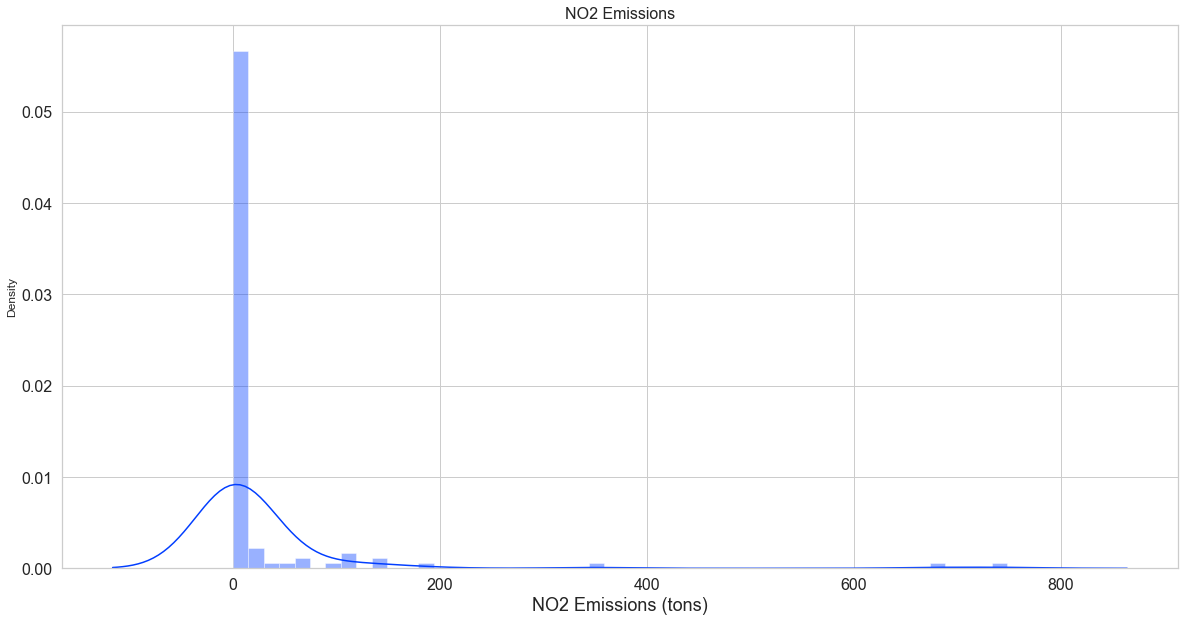

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(Facility_NO2_agg['NO2'], ax = ax)
ax.set_xlabel('NO2 Emissions (tons)', fontsize = 18)
ax.set_title('NO2 Emissions', fontsize = 16)
ax.tick_params(labelsize=16)

We can confirm from the plot that our data is indeed skewed to the right. This seems to be because there are many facilities with small emissions. We will observe for some outliers before considering normalization

### Identifying and Understanding outliers

Text(0.5, 0, 'NO2 Emissions')

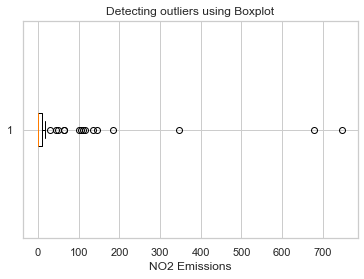

In [48]:
plt.boxplot(Facility_NO2_agg['NO2'], vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('NO2 Emissions')


#sns.set(style = 'whitegrid')
#sns.set_palette('bright')
#fig, ax = plt.subplots(figsize=(40, 30))
#sns.boxplot(
    #x="source_type", 
    #y="NO2",
    #hue="source_type",
    #palette="Set2",
    #data=Facility_NO2,
    #width = 0.5,
    #dodge = False,
    #order =median_Facility_NO2.index.values
    #)
#ax.set_xlabel('Source-Type', fontsize = 35)
#ax.set_title('NO2 Emissions - Group by Source Type', fontsize = 35)
#ax.tick_params(labelsize=30, rotation = 90)
#ax.legend_.remove()
#ax.set_yscale('log')
#ax.set_ylim(0,500)
#ax.set_ylabel('NO2 Emissions (tons) - Log Scale', fontsize = 40)

In [49]:
Facility_NO2_agg.sort_values('NO2', ascending = False).head(30)

,eis_facility_id,company,source_category,latitude,longitude,city,source_type,NO2
12,4762811,HOUSTON-REFINING-LP,Petroleum-Refinery,29.712500,-95.235833,HOUSTON,Petroleum-Refinery,748.190500
39,9129011,Unknown,Airport,29.651395,-95.276559,Houston,Airport,677.868322
9,4168611,TPC-GROUP-LLC,Chemical-Plant,29.698450,-95.254597,HOUSTON,ChemicalPlant,346.698700
29,6510011,CHANNEL-ENERGY-CENTER-LLC,Electricity-Generation-via-Combustion,29.718639,-95.232100,HOUSTON,EGen,183.136600
34,6642511,FLINT-HILLS-RESOURCES-HOUSTON-CHEMICAL-LLC,Chemical-Plant,29.701111,-95.250555,HOUSTON,ChemicalPlant,144.533100
11,4182511,VALERO-REFINING-TEXAS-LP,Petroleum-Refinery,29.722274,-95.254401,HOUSTON,Petroleum-Refinery,136.169300
117,18343611,Unknown,Rail-Yard,29.713963,-95.332765,Harris-Co,RailYard,114.958800
97,14464611,Unknown,Rail-Yard,29.787702,-95.315257,Unknown,RailYard,111.376500
33,6642011,ATLANTIC-COFFEE-INDUSTRIAL-SOLUTIONS-LLC,Food-Products-Processing-Plant,29.745489,-95.337594,HOUSTON,FoodProcessing,106.224300
16,4925211,CITY-OF-HOUSTON,Wastewater-Treatment-Facility,29.756083,-95.308656,HOUSTON,WWTP,99.658000


To normalize our data, we will use the boxcox transformation

### Box-Cox Transformation

In [50]:
Facility_NO2_agg['NO2-transform'] = boxcox(Facility_NO2_agg['NO2'], lmbda=0.0)

### Histogram of transformed NO2 Emissions 

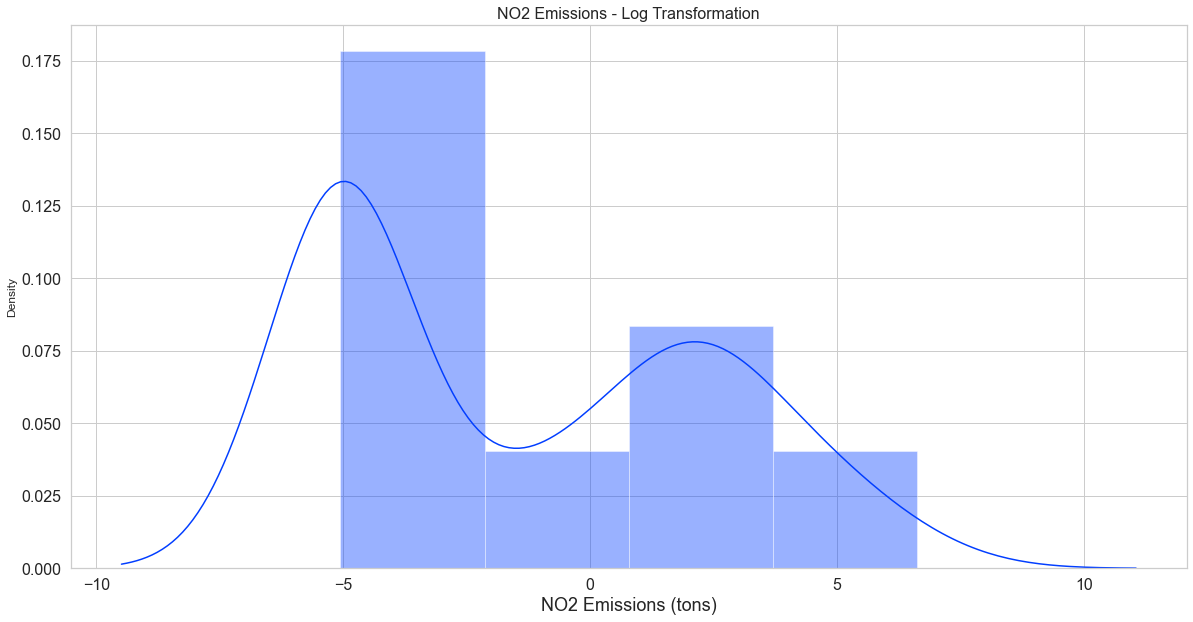

In [51]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(Facility_NO2_agg['NO2-transform'], ax = ax)
ax.set_xlabel('NO2 Emissions (tons)', fontsize = 18)
ax.set_title('NO2 Emissions - Log Transformation', fontsize = 16)
ax.tick_params(labelsize=16)

We see that this log transformed data somewhat follows the normal curve more than the non-transformed data. Hence we'll use the log transformed data moving forward

## Bucketing Emission Sources into relevant groups

### Analysis of NO2 Emissions Data grouped by Source type

In [52]:
Facility_NO2_agg.groupby('source_type').describe()['NO2'].sort_values('count')

,count,mean,std,min,25%,50%,75%,max
source_type,,,,,,,,
GlassPlant,1.0,64.554000,NaN,64.554000,64.554000,64.554000,64.554000,64.554000
SyntheticManufacturing,1.0,12.856600,NaN,12.856600,12.856600,12.856600,12.856600,12.856600
PetroleumStorage,1.0,0.024900,NaN,0.024900,0.024900,0.024900,0.024900,0.024900
Foundaries,1.0,2.697300,NaN,2.697300,2.697300,2.697300,2.697300,2.697300
EGen,1.0,183.136600,NaN,183.136600,183.136600,183.136600,183.136600,183.136600
WWTP,1.0,99.658000,NaN,99.658000,99.658000,99.658000,99.658000,99.658000
Breweries,1.0,15.845900,NaN,15.845900,15.845900,15.845900,15.845900,15.845900
FoodProcessing,2.0,57.345450,69.125133,8.466600,32.906025,57.345450,81.784875,106.224300
Institution,2.0,7.994500,6.182093,3.623100,5.808800,7.994500,10.180200,12.365900


### Box Plot of NO2 Emissions by Source Type

We will now create a box plot by source-type to identify and combine sources of emissions that are small

In [53]:
Facility_NO2_long = pd.melt(
    Facility_NO2_agg, id_vars='source_type', value_vars = 'NO2')

In [54]:
Facility_NO2_long.head(50)

,source_type,variable,value
0,Unknown,NO2,1.222000
1,Unknown,NO2,0.310000
2,Unknown,NO2,0.734100
3,HeatingFacility,NO2,17.975200
4,FoodProcessing,NO2,8.466600
5,Foundaries,NO2,2.697300
6,HeatingFacility,NO2,0.592400
7,Unknown,NO2,3.102000
8,Unknown,NO2,3.769100
9,ChemicalPlant,NO2,346.698700


To ensure that our boxplot is arranged in decreasing median of source emissions from left to right (for easier visual interpretation), we will create an index variable that sorts the source_types in descending of their median emission values

In [55]:
# Sort the index by descending order
median_Facility_NO2 = Facility_NO2_long.groupby('source_type').median()
median_Facility_NO2.sort_values(
    by = 'value', ascending=False, inplace=True)
median_Facility_NO2.index.values

array(['Petroleum-Refinery', 'EGen', 'ChemicalPlant', 'WWTP',
       'GlassPlant', 'FoodProcessing', 'Breweries', 'HeatingFacility',
       'SyntheticManufacturing', 'RailYard', 'AsphaltPlant',
       'Institution', 'Foundaries', 'Bakeries', 'Unknown',
       'PetroleumStorage', 'Airport'], dtype=object)

Text(0, 0.5, 'NO2 Emissions (tons) - Log Scale')

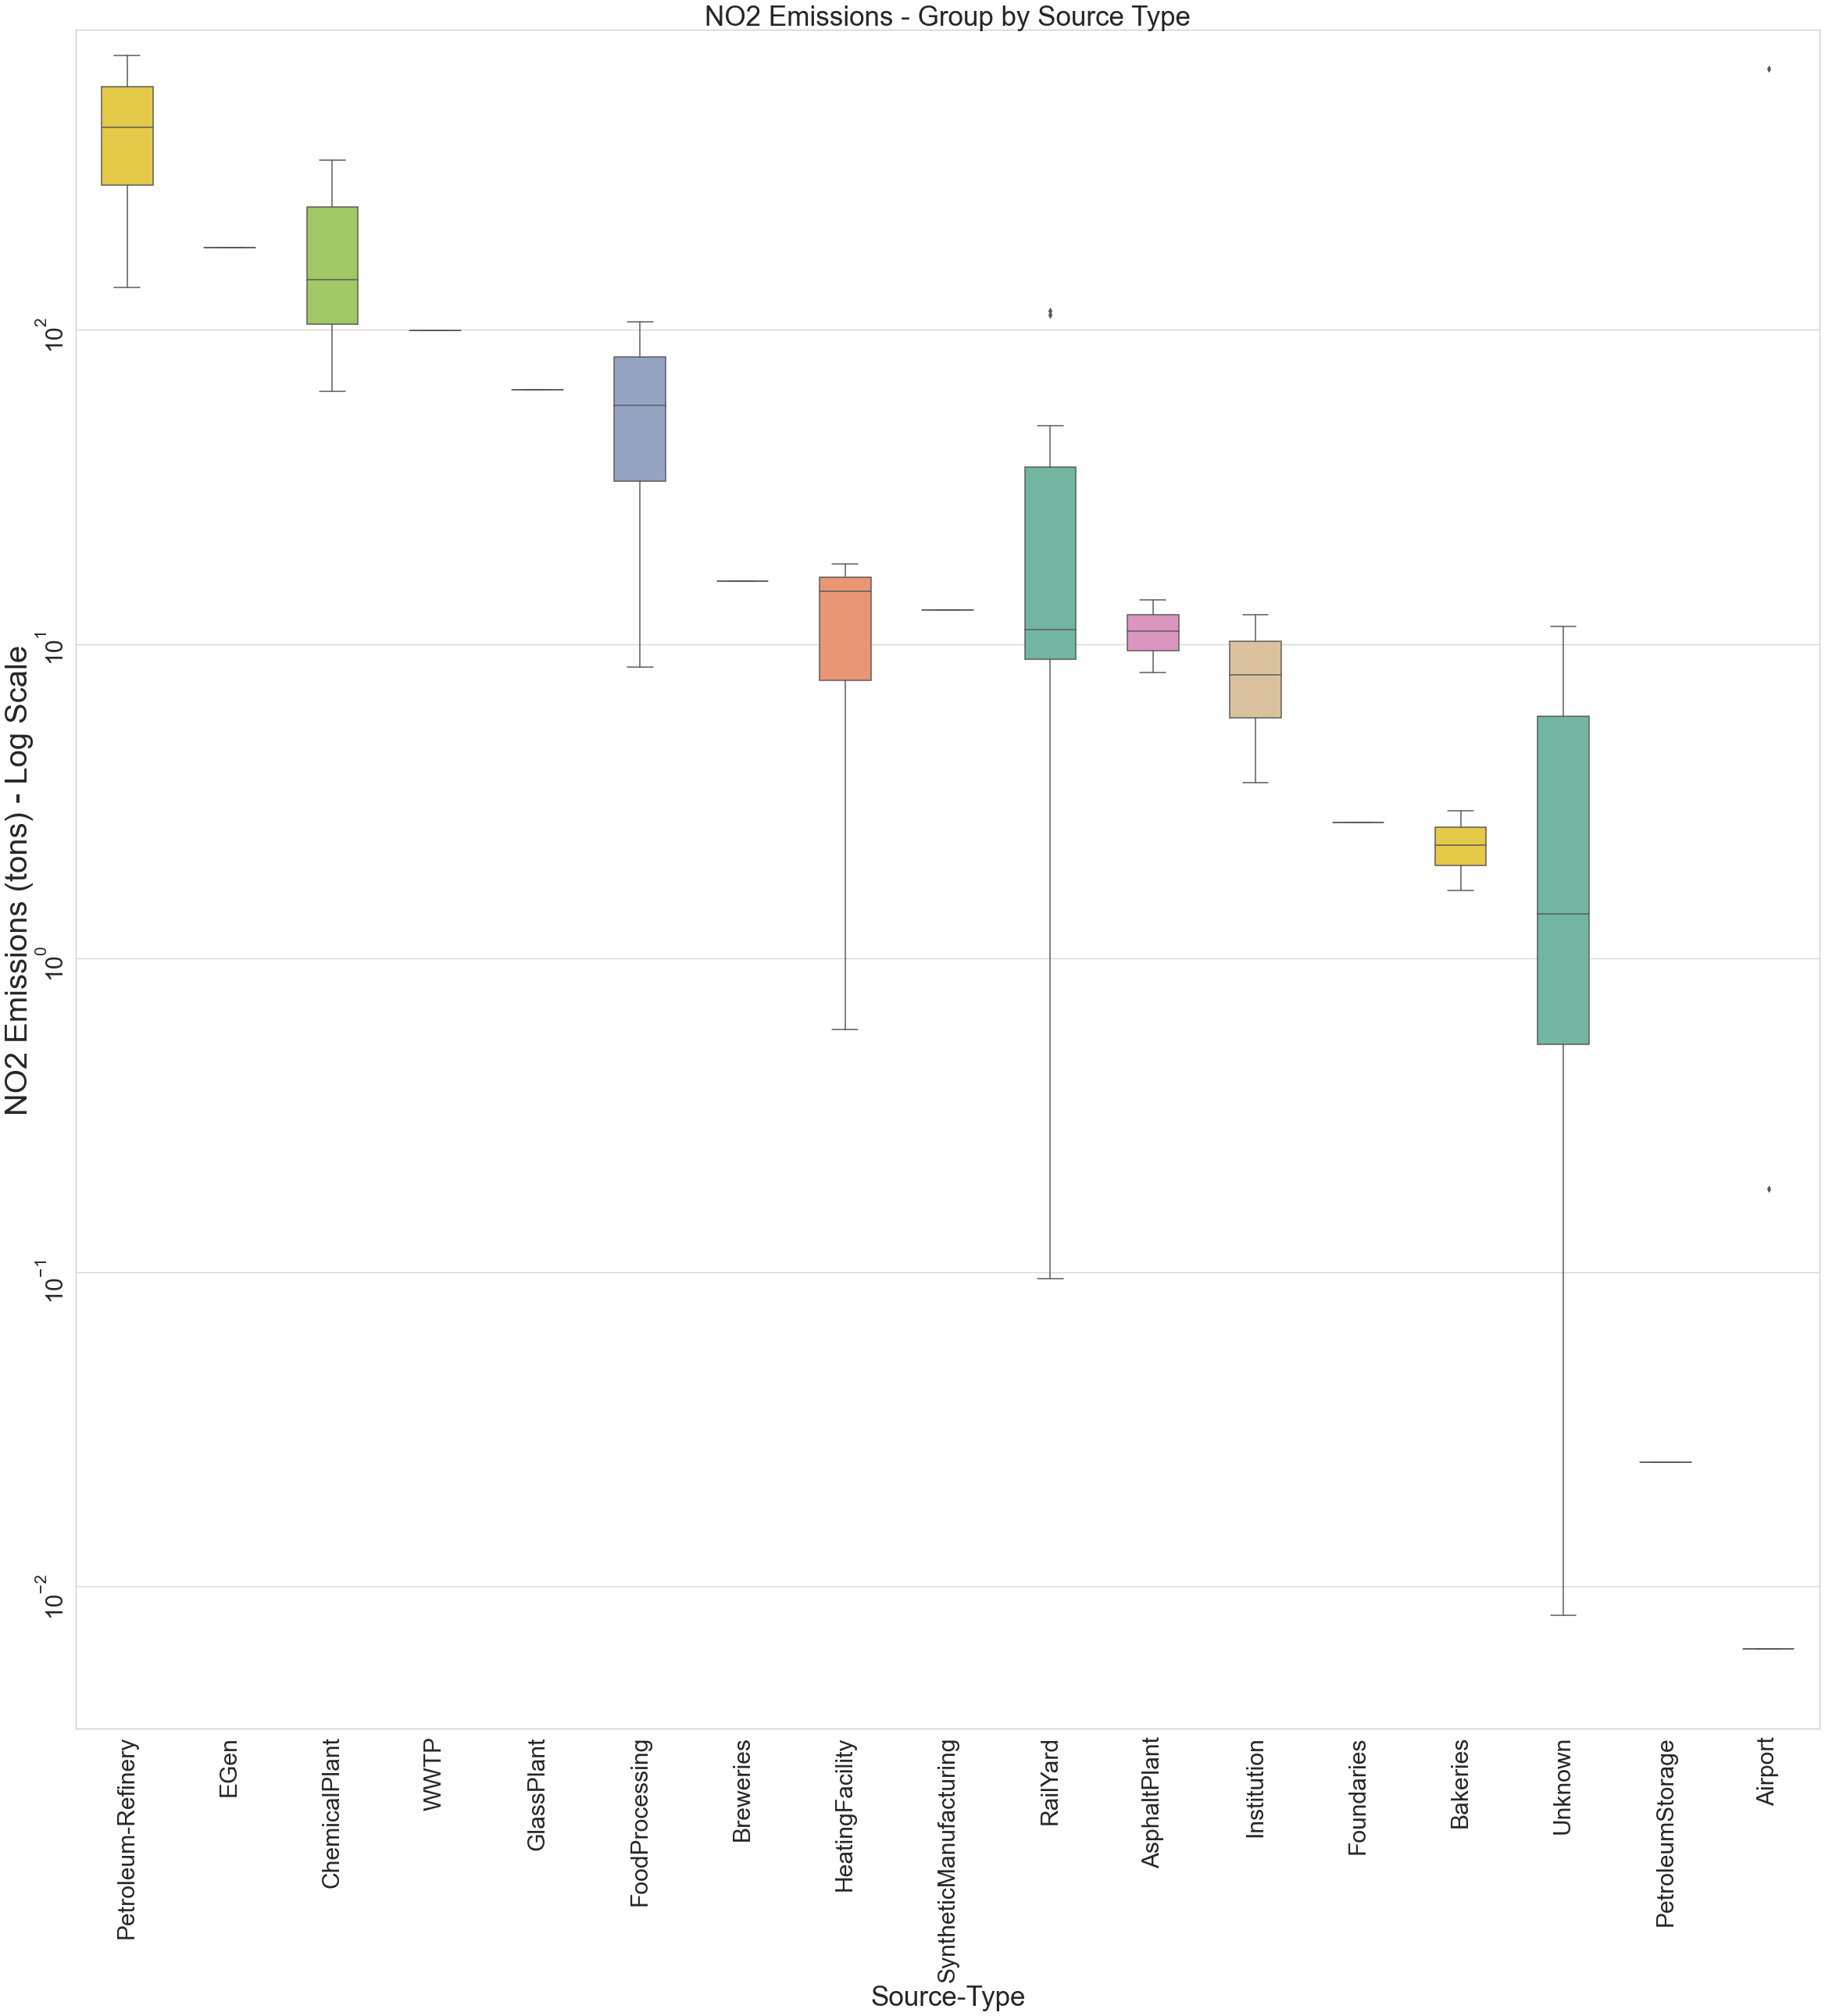

In [57]:
#### Box-plot of NO2 data by source type
sns.set(style = 'whitegrid')
sns.set_palette('bright')
fig, ax = plt.subplots(figsize=(40, 40))
sns.boxplot(
    x="source_type", 
    y="value",
    hue="source_type",
    palette="Set2",
    data=Facility_NO2_long,
    width = 0.5,
    dodge = False,
    order =median_Facility_NO2.index.values)
ax.set_xlabel('Source-Type', fontsize = 35)
ax.set_title('NO2 Emissions - Group by Source Type', fontsize = 35)
ax.tick_params(labelsize=30, rotation = 90)
ax.legend_.remove()
ax.set_yscale('log')
ax.set_ylim(0,900)
ax.set_ylabel('NO2 Emissions (tons) - Log Scale', fontsize = 40)

From the graph above, we see that there are a few large sources of emissions (Railyard, EGen, Chemical Plants, Petroleum Refineries etc.). 

|Large Categories|`source_type`|
|:---:|:---|
|RailYard|RailYard|
|GlassPlant|GlassPlant|
|Foundaries|Foundaries|
|SyntheticManufacturing|SyntheticManufacturing|
|Institution|Institution|
|Airport|Airport|
|Unknown|Unknown|

We can combine the rest under relevant categories to reduce the number of distinct source_types as below:

|Combined Groups|`source_type`|
|:---:|:---|
|Petroelum|Petroleum-Refinery, PetroleumStorage|
|Electricity-Heating|EGen, HeatingFacility|
|ChemicalPlant|ChemicalPlant, WWTP, AsphaltPlant|
|FoodPlant|Breweries, Bakeries, FoodProcessing|

### Combining Source Types into few groups

In [58]:
# Petroleum <--> Petroleum-Refinery, PetroleumStorage

Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'Petroleum-Refinery') | 
                 (Facility_NO2_agg['source_type'] == 'PetroleumStorage'),
                 'source_group'] = 'Petroleum'

In [59]:
# Electricity-Heating <--> EGen, HeatingFacility

Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'EGen') | 
                 (Facility_NO2_agg['source_type'] == 'HeatingFacility'),
                 'source_group'] = 'Electricity-Heating'

In [60]:
# ChemicalPlant <--> ChemicalPlant, WWTP, AsphaltPlant

Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'ChemicalPlant') | 
                 (Facility_NO2_agg['source_type'] == 'WWTP') |
                 (Facility_NO2_agg['source_type'] == 'AsphaltPlant'),
                 'source_group'] = 'ChemicalPlant'

In [61]:
# FoodPlant <--> Breweries, Bakeries, FoodProcessing

Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'Breweries') | 
                 (Facility_NO2_agg['source_type'] == 'Bakeries') |
                 (Facility_NO2_agg['source_type'] == 'FoodProcessing'),
                 'source_group'] = 'FoodPlant'

In [62]:
# Adding source_group column for the pending source_types

Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'RailYard'),
                 'source_group'] = 'RailYard'
Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'GlassPlant'),
                 'source_group'] = 'GlassPlant'
Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'Foundaries'),
                 'source_group'] = 'Foundaries'
Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'SyntheticManufacturing'),
                 'source_group'] = 'SyntheticManufacturing'
Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'Institution'),
                 'source_group'] = 'Institution'
Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'Airport'),
                 'source_group'] = 'Airport'
Facility_NO2_agg.loc[(Facility_NO2_agg['source_type'] == 'Unknown'),
                 'source_group'] = 'Unknown'

### Box Plot of NO2 Emissions by 'Combined' Source Groups

In [63]:
Facility_NO2_grp_long = pd.melt(
    Facility_NO2_agg, id_vars='source_group', value_vars = 'NO2')

In [64]:
Facility_NO2_grp_long.head(50)

,source_group,variable,value
0,Unknown,NO2,1.222000
1,Unknown,NO2,0.310000
2,Unknown,NO2,0.734100
3,Electricity-Heating,NO2,17.975200
4,FoodPlant,NO2,8.466600
5,Foundaries,NO2,2.697300
6,Electricity-Heating,NO2,0.592400
7,Unknown,NO2,3.102000
8,Unknown,NO2,3.769100
9,ChemicalPlant,NO2,346.698700


To ensure that our boxplot is arranged in decreasing median of source emissions from left to right (for easier visual interpretation), we will create an index variable that sorts the source_groups in descending of their median emission values

In [65]:
# Sort the index by descending order
median_Facility_NO2_grp = Facility_NO2_grp_long.groupby('source_group').median()
median_Facility_NO2_grp.sort_values(
    by = 'value', ascending=False, inplace=True)
median_Facility_NO2_grp.index.values

array(['Petroleum', 'ChemicalPlant', 'GlassPlant', 'Electricity-Heating',
       'SyntheticManufacturing', 'RailYard', 'FoodPlant', 'Institution',
       'Foundaries', 'Unknown', 'Airport'], dtype=object)

Text(0, 0.5, 'NO2 Emissions (tons) - Log Scale')

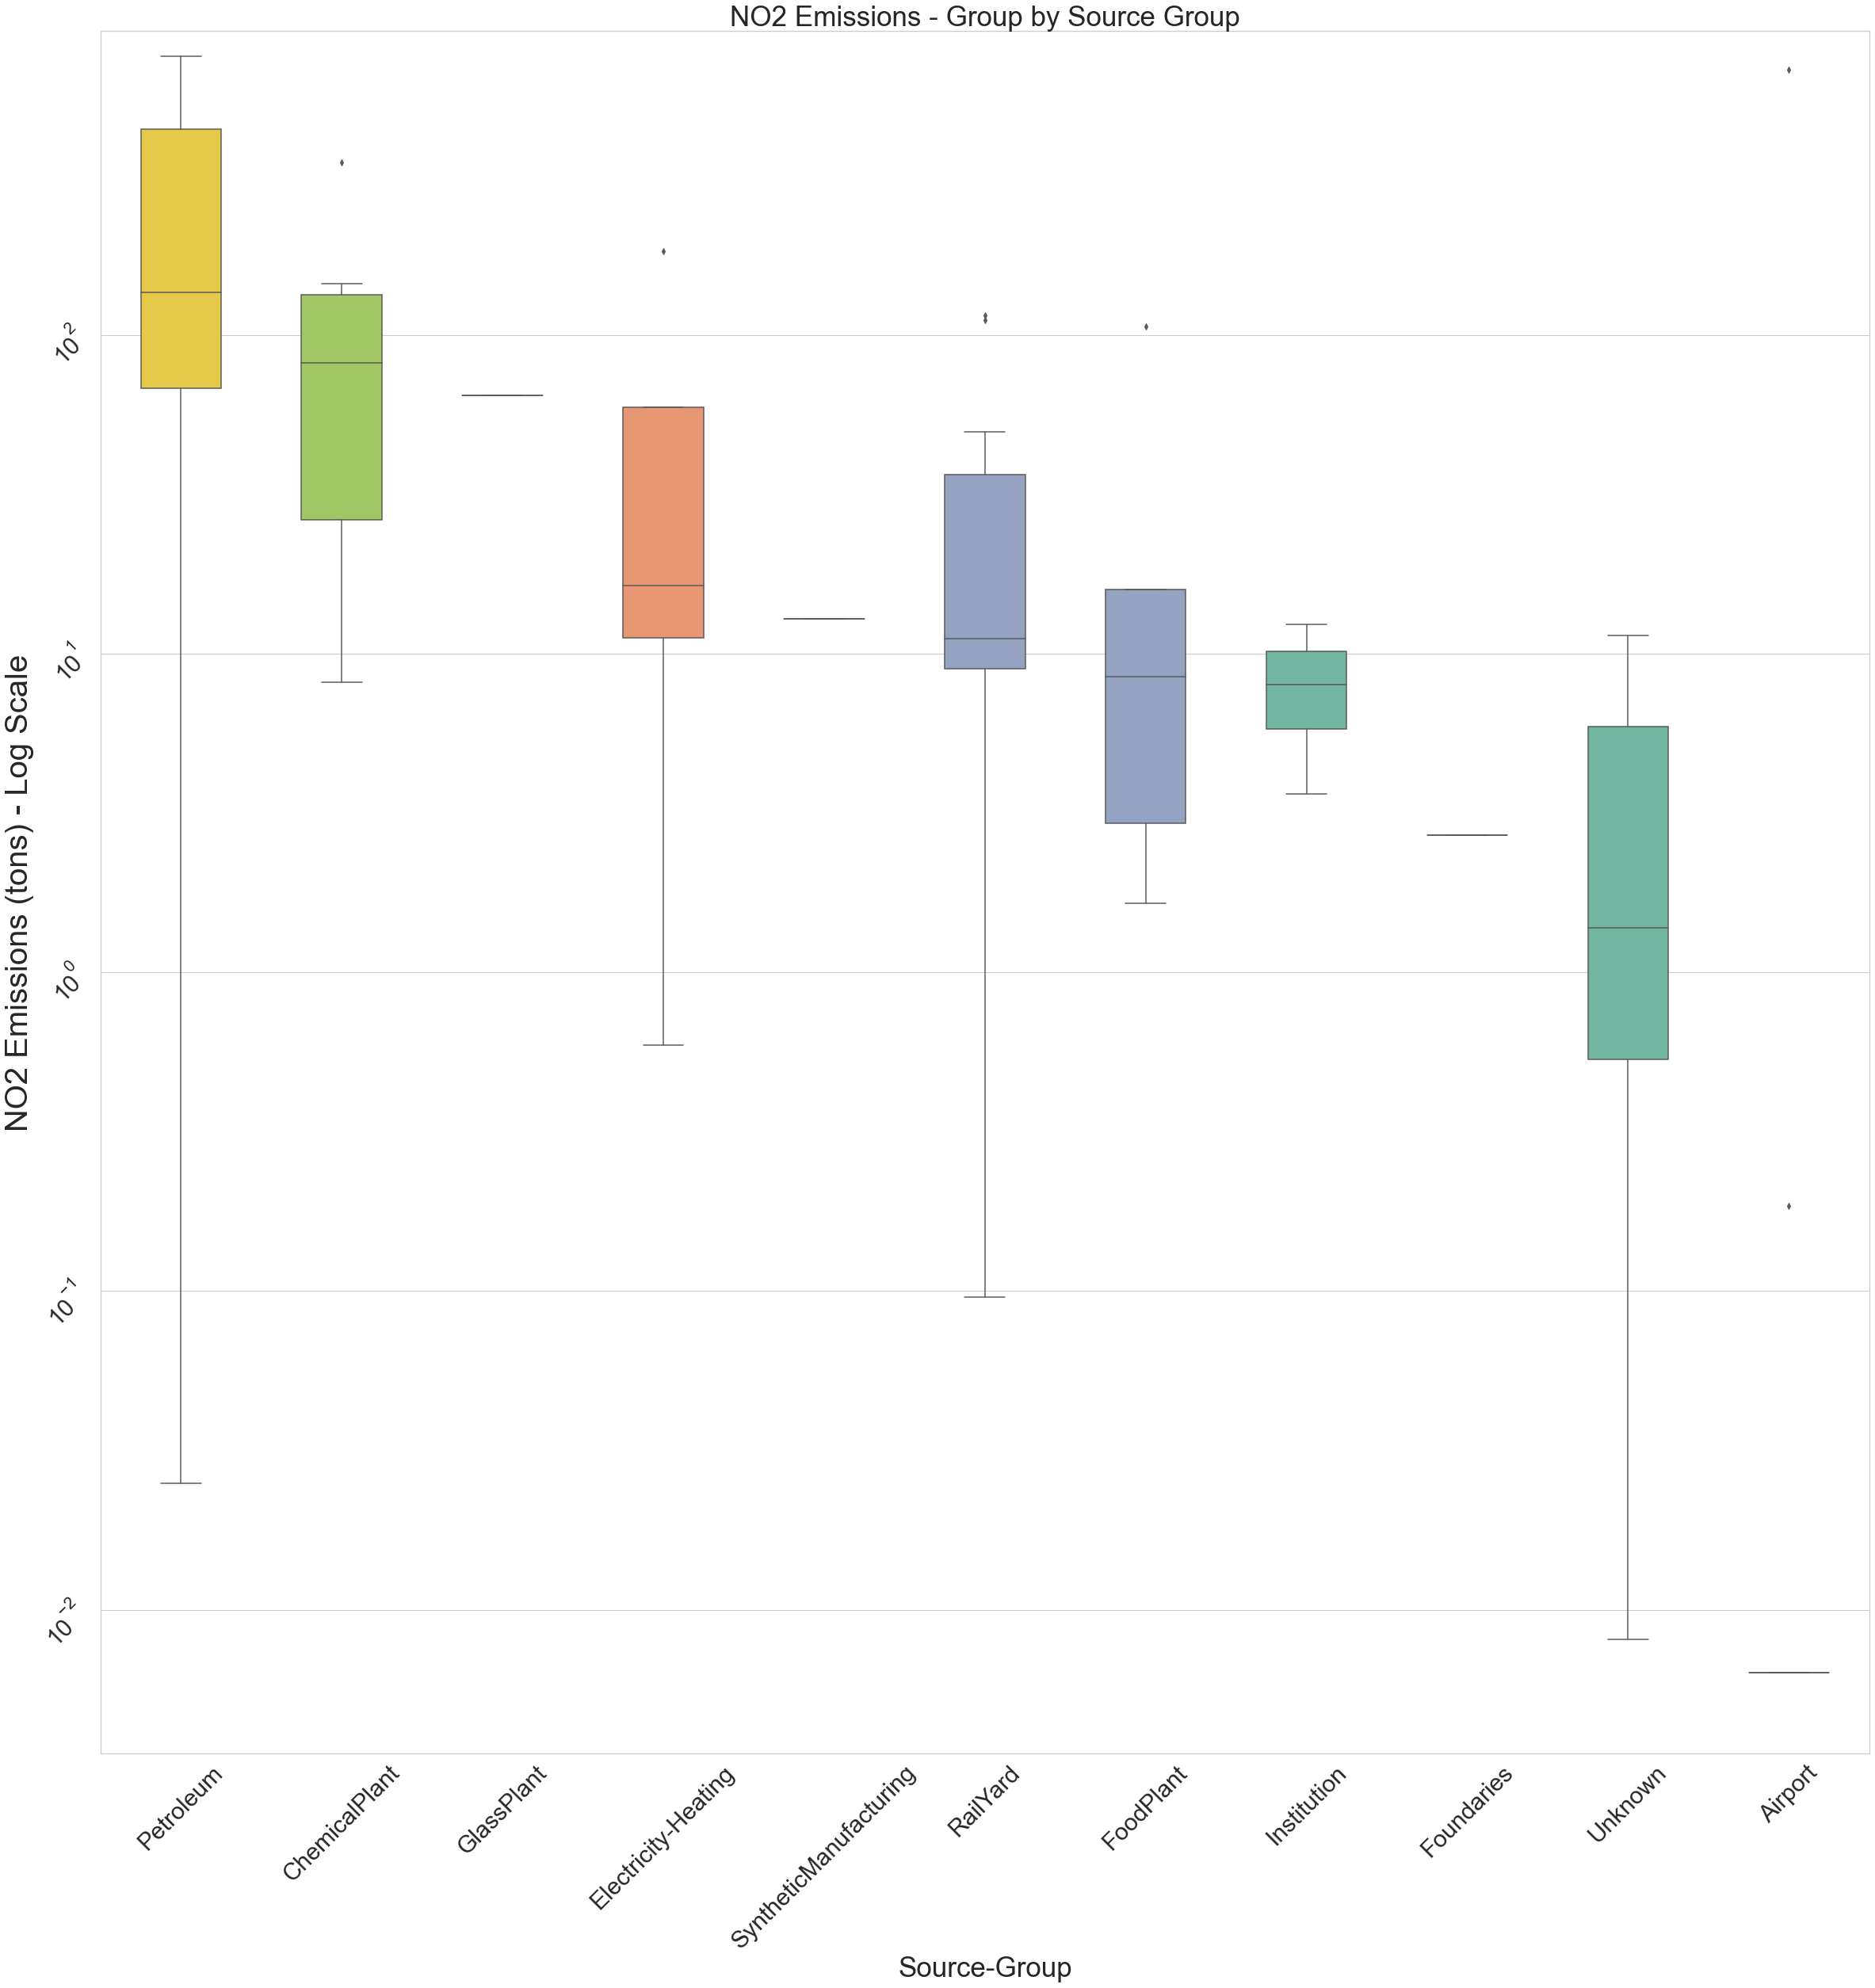

In [67]:
#### Box-plot of NO2 data by source type
sns.set(style = 'whitegrid')
sns.set_palette('bright')
fig, ax = plt.subplots(figsize=(40, 40))
sns.boxplot(
    x="source_group", 
    y="value",
    hue="source_group",
    palette="Set2",
    data=Facility_NO2_grp_long,
    width = 0.5,
    dodge = False,
    order =median_Facility_NO2_grp.index.values)
ax.set_xlabel('Source-Group', fontsize = 35)
ax.set_title('NO2 Emissions - Group by Source Group', fontsize = 35)
ax.tick_params(labelsize=30, rotation = 45)
ax.legend_.remove()
ax.set_yscale('log')
ax.set_ylim(0,900)
ax.set_ylabel('NO2 Emissions (tons) - Log Scale', fontsize = 40)

## Binning facilities based on emission quantities

Now we'll categorize each facility as 'Low/Medium/High' depending on the qunatity of emissions, based on the below criterion:
- Emissions Lower than first quartile: Low
- Emissions between first and third quartile: Medium
- Emissions above third quartile: High

In [71]:
Facility_NO2_agg.describe()['NO2']

count    119.000000
mean      26.875735
std      100.416398
min        0.006349
25%        0.006349
50%        0.093000
75%        9.760250
max      748.190500
Name: NO2, dtype: float64

In [75]:
Facility_NO2_agg.loc[:,'ems_level'] = pd.qcut(
    Facility_NO2_agg['NO2'], q = [0, 0.50, 0.75, 1.0], 
    labels=["low", "medium", "high"])

In [76]:
Facility_NO2.to_csv("Facility_NO2_GrpBin.csv")

In [78]:
NO2_count_df = Facility_NO2_agg.groupby(
    ['ems_level','source_group'])['eis_facility_id'].count().reset_index()

In [79]:
NO2_count_df = NO2_count_df.pivot(
    index = 'ems_level', 
    columns = 'source_group', values = 'eis_facility_id')

In [80]:
NO2_count_df.head()

source_group,Airport,ChemicalPlant,Electricity-Heating,FoodPlant,Foundaries,GlassPlant,Institution,Petroleum,RailYard,SyntheticManufacturing,Unknown
ems_level,,,,,,,,,,,
low,56,0,0,0,0,0,0,1,0,0,3
medium,1,1,1,3,1,0,1,0,4,0,17
high,1,5,3,2,0,1,1,2,11,1,3


Text(0.5, 0, 'Emission Levels')

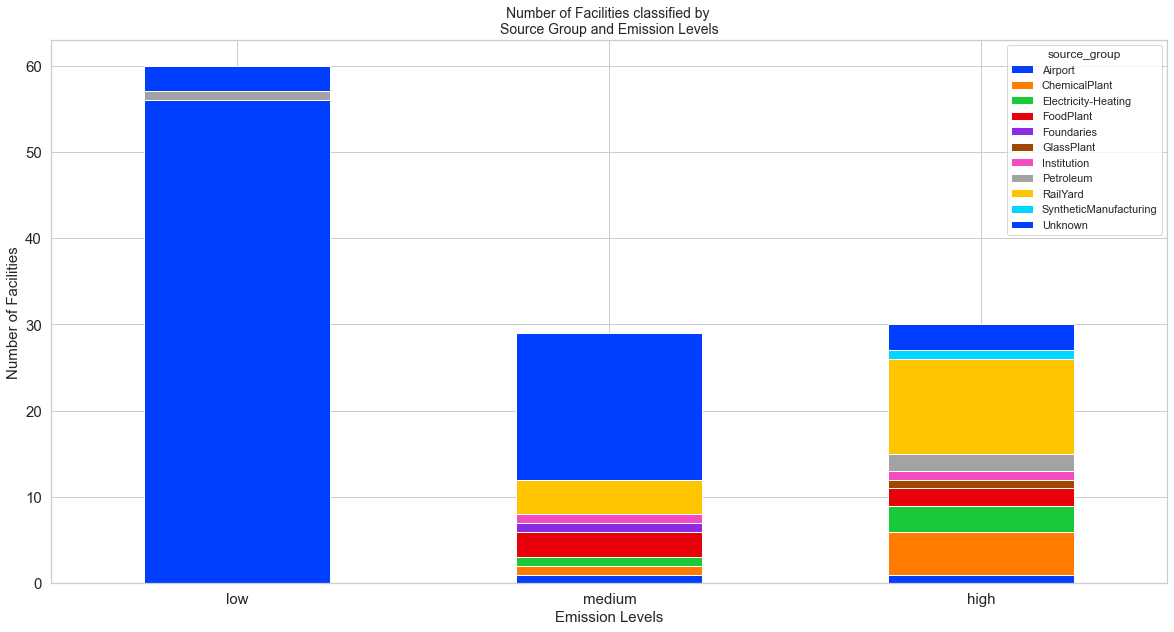

In [81]:
fig, ax = plt.subplots(figsize=(20, 10))
NO2_count_df.loc[:,sorted(
    Facility_NO2_agg.source_group.unique())].plot.bar(stacked=True,ax= ax)
ax.set_title("""Number of Facilities classified by 
Source Group and Emission Levels""", fontsize = 14)
ax.tick_params(labelsize=15, rotation = 0)
ax.set_ylabel('Number of Facilities', fontsize = 15)
ax.set_xlabel('Emission Levels', fontsize = 15)

# Importing Air Pollution Monitoring Data from EDF

In [82]:
NO2_df_raw = pd.read_csv("air_quality_NO2.csv", header = 0)
NO2_df_raw.head(50)

,Unnamed: 0,locationId,location,city,country,utc,local,parameter,value,unit,latitude,longitude
0,0,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000517,ppm,29.789446,-95.483822
1,1,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000756,ppm,29.750588,-95.419853
2,2,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001427,ppm,29.810590,-95.348540
3,3,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001262,ppm,29.786917,-95.298818
4,4,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000803,ppm,29.604903,-95.364682
5,5,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001147,ppm,29.785591,-95.296266
6,6,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.002066,ppm,29.784273,-95.476275
7,7,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.001197,ppm,29.602555,-95.317850
8,8,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000666,ppm,29.728483,-95.550811
9,9,61509,NaN,Houston,US,2018-03-31T06:00:00+00:00,2018-03-31T01:00:00-05:00,no2,0.000535,ppm,29.805404,-95.405685


In [112]:
len(NO2_df_raw.index)

11534

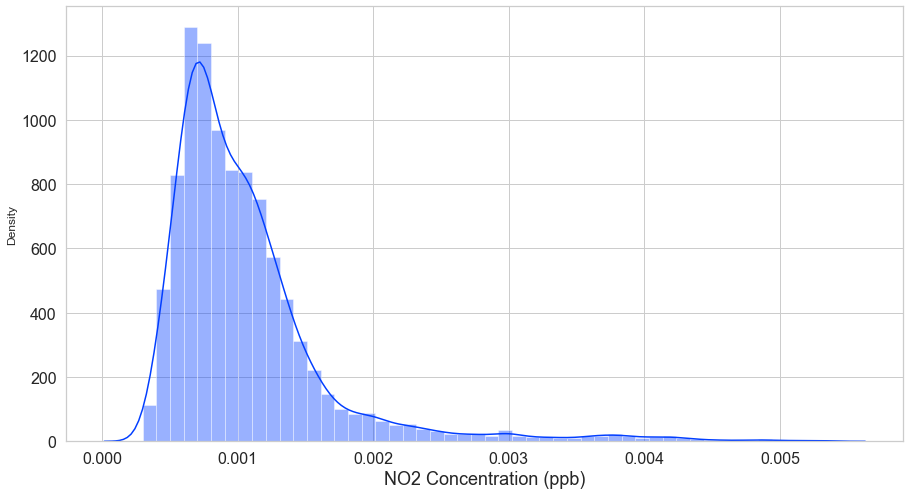

In [83]:
figure, ax = plt.subplots(figsize = (15,8))
sns.distplot(NO2_df_raw['value'], ax = ax)
ax.set_xlabel('NO2 Concentration (ppb)', fontsize = 18)
ax.tick_params(labelsize=16)

We see that the distribution of NO2 concentration from the pollution data is almost normal, so we can use it as-is, without any transformation

In [84]:
NO2_df_raw.describe()

,Unnamed: 0,locationId,location,value,latitude,longitude
count,11534.000000,11534.0,0.0,11534.000000,11534.000000,11534.000000
mean,5766.500000,61509.0,NaN,0.001059,29.728743,-95.378613
std,3329.723337,0.0,NaN,0.000613,0.059185,0.090387
min,0.000000,61509.0,NaN,0.000300,29.598099,-95.557709
25%,2883.250000,61509.0,NaN,0.000686,29.702324,-95.434617
50%,5766.500000,61509.0,NaN,0.000911,29.727755,-95.382017
75%,8649.750000,61509.0,NaN,0.001221,29.780144,-95.300010
max,11533.000000,61509.0,NaN,0.005345,29.814020,-95.228483


In [85]:
NO2_df_raw.columns

Index(['Unnamed: 0', 'locationId', 'location', 'city', 'country', 'utc',
       'local', 'parameter', 'value', 'unit', 'latitude', 'longitude'],
      dtype='object')

In [86]:
# Dropping unnecessary columns
NO2_df_raw.drop(
    columns = ['Unnamed: 0', 'locationId', 'location', 
               'country', 'utc', 'local', 'parameter',
               'city'], inplace = True)

In [87]:
NO2_df = NO2_df_raw[['latitude', 'longitude','value','unit']]
NO2_df.head()

,latitude,longitude,value,unit
0,29.789446,-95.483822,0.000517,ppm
1,29.750588,-95.419853,0.000756,ppm
2,29.810590,-95.348540,0.001427,ppm
3,29.786917,-95.298818,0.001262,ppm
4,29.604903,-95.364682,0.000803,ppm


# Calculating distance between facility and pollution monitor location

In the next steps we will:
1. Calculate the distance between an emission point and all the facilities in the region
2. Calculate a measure of emission/distance for each of these emission points - which will measure the emission from the facility per unit distance from the facility corresponding to the emission point

In [88]:
# Retain a copy of the Facility_NO2 dataframe without distance values
Facility_NO2 = Facility_NO2_agg.copy()

In [89]:
len(Facility_NO2.index)

119

In [90]:
Facility_NO2.head()

,eis_facility_id,company,source_category,latitude,longitude,city,source_type,NO2,NO2-transform,source_group,ems_level
0,3687811,NCI-GROUP-INC,Unknown,29.752803,-95.313967,HOUSTON,Unknown,1.2220,0.200489,Unknown,medium
1,3688211,PAN-GLO-SERVICES-LLC,Unknown,29.657522,-95.231043,PASADENA,Unknown,0.3100,-1.171183,Unknown,medium
2,3688311,INDUSTRIAL-METAL-FINISHING-CO,Unknown,29.695278,-95.353333,HOUSTON,Unknown,0.7341,-0.309110,Unknown,medium
3,3689111,RICE-UNIVERSITY,Steam-Heating-Facility,29.718028,-95.403564,HOUSTON,HeatingFacility,17.9752,2.888993,Electricity-Heating,high
4,3689311,JACOB-STERN-AND-SONS-INC,Food-Products-Processing-Plant,29.741944,-95.287778,HOUSTON,FoodProcessing,8.4666,2.136129,FoodPlant,medium


In [91]:
### Create a column as eis-source-group by combining the source_group and EIS ID for each facility
Facility_NO2['eis-source'] = Facility_NO2['eis_facility_id'].apply(str) + '-' +  Facility_NO2['source_group'].apply(str)

### Create a column as eis-source-ems-type by combining emission levels with eis-source
Facility_NO2['eis-source-ems'] = Facility_NO2['eis-source'].apply(str) + '-' + Facility_NO2.ems_level.astype(str)

In [92]:
len(Facility_NO2.index)

119

In [93]:
### Add an empty column for distance
Facility_NO2['dist'] = 0
Facility_NO2['dist'].astype(float)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
114    0.0
115    0.0
116    0.0
117    0.0
118    0.0
Name: dist, Length: 119, dtype: float64

In [94]:
### Add an empty column for emission/distance
Facility_NO2['emsdist'] = 0
Facility_NO2['emsdist'].astype(float)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
114    0.0
115    0.0
116    0.0
117    0.0
118    0.0
Name: emsdist, Length: 119, dtype: float64

In [95]:
# Create individual dataframes
Houston_NO2_lat = Facility_NO2[['eis-source-ems', 'latitude']]
Houston_NO2_long = Facility_NO2[['eis-source-ems', 'longitude']]
Houston_NO2_NO2 = Facility_NO2[['eis-source-ems', 'NO2']]
Houston_NO2_dist = Facility_NO2[['eis-source-ems', 'dist']]
Houston_NO2_emsdist = Facility_NO2[['eis-source-ems', 'emsdist']]

In [96]:
Facility_NO2[['eis-source-ems', 'latitude']]

,eis-source-ems,latitude
0,3687811-Unknown-medium,29.752803
1,3688211-Unknown-medium,29.657522
2,3688311-Unknown-medium,29.695278
3,3689111-Electricity-Heating-high,29.718028
4,3689311-FoodPlant-medium,29.741944
...,...,...
114,17872111-RailYard-medium,29.709216
115,17876311-RailYard-high,29.799387
116,17977311-Unknown-medium,29.723278
117,18343611-RailYard-high,29.713963


In [97]:
# Transpose all the dataframes
Houston_NO2_lat = Houston_NO2_lat.T
Houston_NO2_long = Houston_NO2_long.T
Houston_NO2_NO2 = Houston_NO2_NO2.T
Houston_NO2_dist = Houston_NO2_dist.T
Houston_NO2_emsdist = Houston_NO2_emsdist.T

In [98]:
# Make the header as the first row in each transposed dataframe
Houston_NO2_lat = Houston_NO2_lat.rename(
    columns=Houston_NO2_lat.iloc[0]).drop(Houston_NO2_lat.index[0])

Houston_NO2_long = Houston_NO2_long.rename(
    columns=Houston_NO2_long.iloc[0]).drop(Houston_NO2_long.index[0])

Houston_NO2_NO2 = Houston_NO2_NO2.rename(
    columns=Houston_NO2_NO2.iloc[0]).drop(Houston_NO2_NO2.index[0])

Houston_NO2_dist = Houston_NO2_dist.rename(
    columns=Houston_NO2_dist.iloc[0]).drop(Houston_NO2_dist.index[0])

Houston_NO2_emsdist = Houston_NO2_emsdist.rename(
    columns=Houston_NO2_emsdist.iloc[0]).drop(Houston_NO2_emsdist.index[0])

In [99]:
# Add suffix to column header based on the dataframe type
Houston_NO2_lat.columns = [str(col) + '_latitude' for col in Houston_NO2_lat.columns]
Houston_NO2_long.columns = [str(col) + '_longitude' for col in Houston_NO2_long.columns]
Houston_NO2_NO2.columns = [str(col) + '_NO2' for col in Houston_NO2_NO2.columns]
Houston_NO2_dist.columns = [str(col) + '_dist' for col in Houston_NO2_dist.columns]
Houston_NO2_emsdist.columns = [str(col) + '_emsdist' for col in Houston_NO2_emsdist.columns]

In [100]:
# Remove index for each dataframe
Houston_NO2_lat.reset_index(drop=True, inplace=True)
Houston_NO2_long.reset_index(drop=True, inplace=True)
Houston_NO2_NO2.reset_index(drop=True, inplace=True)
Houston_NO2_dist.reset_index(drop=True, inplace=True)
Houston_NO2_emsdist.reset_index(drop=True, inplace=True)

In [101]:
### Combine individual dataframes into one
Houston_NO2_combined = Houston_NO2_lat.join(Houston_NO2_long).join(
    Houston_NO2_NO2).join(Houston_NO2_dist).join(Houston_NO2_emsdist)

In [102]:
Houston_NO2_lat.head()

,3687811-Unknown-medium_latitude,3688211-Unknown-medium_latitude,3688311-Unknown-medium_latitude,3689111-Electricity-Heating-high_latitude,3689311-FoodPlant-medium_latitude,4055311-Foundaries-medium_latitude,4057311-Electricity-Heating-medium_latitude,4167311-Unknown-medium_latitude,4167511-Unknown-medium_latitude,4168611-ChemicalPlant-high_latitude,4169011-Unknown-medium_latitude,4182511-Petroleum-high_latitude,4762811-Petroleum-high_latitude,4778711-ChemicalPlant-high_latitude,4861111-Petroleum-low_latitude,4924511-Unknown-high_latitude,4925211-ChemicalPlant-high_latitude,4926211-FoodPlant-high_latitude,4926911-Unknown-medium_latitude,4940711-Unknown-high_latitude,4941211-SyntheticManufacturing-high_latitude,4941711-Unknown-high_latitude,4942411-Electricity-Heating-high_latitude,4981411-GlassPlant-high_latitude,6422311-Unknown-low_latitude,6422411-Unknown-medium_latitude,6422911-Unknown-medium_latitude,6436411-ChemicalPlant-high_latitude,6436711-Unknown-low_latitude,6510011-Electricity-Heating-high_latitude,6534911-Unknown-low_latitude,6536711-Unknown-medium_latitude,6615911-Unknown-medium_latitude,6642011-FoodPlant-high_latitude,6642511-ChemicalPlant-high_latitude,6642811-FoodPlant-medium_latitude,6671811-Institution-medium_latitude,6672211-Unknown-medium_latitude,9114211-FoodPlant-medium_latitude,9129011-Airport-high_latitude,10989211-Airport-low_latitude,10999611-Airport-low_latitude,11053511-Airport-low_latitude,11107611-Airport-medium_latitude,11266811-Airport-low_latitude,11543811-Airport-low_latitude,11562211-Airport-low_latitude,11573111-Airport-low_latitude,11579411-Airport-low_latitude,11591711-Airport-low_latitude,11595711-Airport-low_latitude,11612311-Airport-low_latitude,11675911-Airport-low_latitude,11746411-Airport-low_latitude,11765311-Airport-low_latitude,11765711-Airport-low_latitude,11765811-Airport-low_latitude,11768011-Airport-low_latitude,11778411-Airport-low_latitude,11784411-Airport-low_latitude,11818711-Airport-low_latitude,11851811-Airport-low_latitude,11854511-Airport-low_latitude,11869711-Airport-low_latitude,11871511-Airport-low_latitude,11881211-Airport-low_latitude,11892511-Airport-low_latitude,11897711-Airport-low_latitude,11929811-Airport-low_latitude,11944511-Airport-low_latitude,11944611-Airport-low_latitude,11973211-Airport-low_latitude,12007511-Airport-low_latitude,12018611-Airport-low_latitude,12026411-Airport-low_latitude,12031411-Airport-low_latitude,12064511-Airport-low_latitude,12068511-Airport-low_latitude,12068911-Airport-low_latitude,12069011-Airport-low_latitude,12079211-Airport-low_latitude,12080011-Airport-low_latitude,12090811-Airport-low_latitude,12174711-Airport-low_latitude,12208711-Airport-low_latitude,12253411-Airport-low_latitude,12253511-Airport-low_latitude,12253711-Airport-low_latitude,12254111-Airport-low_latitude,12254211-Airport-low_latitude,12254711-Airport-low_latitude,12256711-Airport-low_latitude,12257011-Airport-low_latitude,12257111-Airport-low_latitude,12257211-Airport-low_latitude,12258211-Airport-low_latitude,14464311-RailYard-high_latitude,14464611-RailYard-high_latitude,14487911-RailYard-medium_latitude,14488111-RailYard-high_latitude,14488511-RailYard-high_latitude,14488811-RailYard-high_latitude,14489211-RailYard-high_latitude,14747811-Unknown-medium_latitude,14766711-Institution-high_latitude,15043011-Unknown-medium_latitude,16035911-Airport-low_latitude,16623211-ChemicalPlant-medium_latitude,16912111-RailYard-medium_latitude,16926811-RailYard-high_latitude,16926911-RailYard-medium_latitude,17726411-Unknown-medium_latitude,17737711-Unknown-medium_latitude,17865111-RailYard-high_latitude,17872111-RailYard-medium_latitude,17876311-RailYard-high_latitude,17977311-Unknown-medium_latitude,18343611-RailYard-high_latitude,18343711-RailYard-high_latitude
0,29.752803,29.657522,29.695278,29.718028,29.741944,29.786983,29.702778,29.646531,29.790586,29.69845,29.726986,29.722274,29.7125,29.720281,29.668219,29.7218,29.756083,29.773586,29.810278,29.631275,29.704391,2

In [103]:
### Sort based on column names
Houston_NO2_combined = Houston_NO2_combined.reindex(
    columns=sorted(Houston_NO2_combined.columns))
Houston_NO2_combined

,10989211-Airport-low_NO2,10989211-Airport-low_dist,10989211-Airport-low_emsdist,10989211-Airport-low_latitude,10989211-Airport-low_longitude,10999611-Airport-low_NO2,10999611-Airport-low_dist,10999611-Airport-low_emsdist,10999611-Airport-low_latitude,10999611-Airport-low_longitude,11053511-Airport-low_NO2,11053511-Airport-low_dist,11053511-Airport-low_emsdist,11053511-Airport-low_latitude,11053511-Airport-low_longitude,11107611-Airport-medium_NO2,11107611-Airport-medium_dist,11107611-Airport-medium_emsdist,11107611-Airport-medium_latitude,11107611-Airport-medium_longitude,11266811-Airport-low_NO2,11266811-Airport-low_dist,11266811-Airport-low_emsdist,11266811-Airport-low_latitude,11266811-Airport-low_longitude,11543811-Airport-low_NO2,11543811-Airport-low_dist,11543811-Airport-low_emsdist,11543811-Airport-low_latitude,11543811-Airport-low_longitude,11562211-Airport-low_NO2,11562211-Airport-low_dist,11562211-Airport-low_emsdist,11562211-Airport-low_latitude,11562211-Airport-low_longitude,11573111-Airport-low_NO2,11573111-Airport-low_dist,11573111-Airport-low_emsdist,11573111-Airport-low_latitude,11573111-Airport-low_longitude,11579411-Airport-low_NO2,11579411-Airport-low_dist,11579411-Airport-low_emsdist,11579411-Airport-low_latitude,11579411-Airport-low_longitude,11591711-Airport-low_NO2,11591711-Airport-low_dist,11591711-Airport-low_emsdist,11591711-Airport-low_latitude,11591711-Airport-low_longitude,11595711-Airport-low_NO2,11595711-Airport-low_dist,11595711-Airport-low_emsdist,11595711-Airport-low_latitude,11595711-Airport-low_longitude,11612311-Airport-low_NO2,11612311-Airport-low_dist,11612311-Airport-low_emsdist,11612311-Airport-low_latitude,11612311-Airport-low_longitude,11675911-Airport-low_NO2,11675911-Airport-low_dist,11675911-Airport-low_emsdist,11675911-Airport-low_latitude,11675911-Airport-low_longitude,11746411-Airport-low_NO2,11746411-Airport-low_dist,11746411-Airport-low_emsdist,11746411-Airport-low_latitude,11746411-Airport-low_longitude,11765311-Airport-low_NO2,11765311-Airport-low_dist,11765311-Airport-low_emsdist,11765311-Airport-low_latitude,11765311-Airport-low_longitude,11765711-Airport-low_NO2,11765711-Airport-low_dist,11765711-Airport-low_emsdist,11765711-Airport-low_latitude,11765711-Airport-low_longitude,11765811-Airport-low_NO2,11765811-Airport-low_dist,11765811-Airport-low_emsdist,11765811-Airport-low_latitude,11765811-Airport-low_longitude,11768011-Airport-low_NO2,11768011-Airport-low_dist,11768011-Airport-low_emsdist,11768011-Airport-low_latitude,11768011-Airport-low_longitude,11778411-Airport-low_NO2,11778411-Airport-low_dist,11778411-Airport-low_emsdist,11778411-Airport-low_latitude,11778411-Airport-low_longitude,11784411-Airport-low_NO2,11784411-Airport-low_dist,11784411-Airport-low_emsdist,11784411-Airport-low_latitude,11784411-Airport-low_longitude,11818711-Airport-low_NO2,11818711-Airport-low_dist,11818711-Airport-low_emsdist,11818711-Airport-low_latitude,11818711-Airport-low_longitude,11851811-Airport-low_NO2,11851811-Airport-low_dist,11851811-Airport-low_emsdist,11851811-Airport-low_latitude,11851811-Airport-low_longitude,11854511-Airport-low_NO2,11854511-Airport-low_dist,11854511-Airport-low_emsdist,11854511-Airport-low_latitude,11854511-Airport-low_longitude,11869711-Airport-low_NO2,11869711-Airport-low_dist,11869711-Airport-low_emsdist,11869711-Airport-low_latitude,11869711-Airport-low_longitude,11871511-Airport-low_NO2,11871511-Airport-low_dist,11871511-Airport-low_emsdist,11871511-Airport-low_latitude,11871511-Airport-low_longitude,11881211-Airport-low_NO2,11881211-Airport-low_dist,11881211-Airport-low_emsdist,11881211-Airport-low_latitude,11881211-Airport-low_longitude,11892511-Airport-low_NO2,11892511-Airport-low_dist,11892511-Airport-low_emsdist,11892511-Airport-low_latitude,11892511-Airport-low_longitude,11897711-Airport-low_NO2,11897711-Airport-low_dist,11897711-Airport-low_emsdist,11897711-Airport-low_latitude,11897711-Airport-low_longitude,11929811-Airport-low_NO2,11929811-Ai

In [111]:
Houston_NO2_combined

,10989211-Airport-low_NO2,10989211-Airport-low_dist,10989211-Airport-low_emsdist,10989211-Airport-low_latitude,10989211-Airport-low_longitude,10999611-Airport-low_NO2,10999611-Airport-low_dist,10999611-Airport-low_emsdist,10999611-Airport-low_latitude,10999611-Airport-low_longitude,11053511-Airport-low_NO2,11053511-Airport-low_dist,11053511-Airport-low_emsdist,11053511-Airport-low_latitude,11053511-Airport-low_longitude,11107611-Airport-medium_NO2,11107611-Airport-medium_dist,11107611-Airport-medium_emsdist,11107611-Airport-medium_latitude,11107611-Airport-medium_longitude,11266811-Airport-low_NO2,11266811-Airport-low_dist,11266811-Airport-low_emsdist,11266811-Airport-low_latitude,11266811-Airport-low_longitude,11543811-Airport-low_NO2,11543811-Airport-low_dist,11543811-Airport-low_emsdist,11543811-Airport-low_latitude,11543811-Airport-low_longitude,11562211-Airport-low_NO2,11562211-Airport-low_dist,11562211-Airport-low_emsdist,11562211-Airport-low_latitude,11562211-Airport-low_longitude,11573111-Airport-low_NO2,11573111-Airport-low_dist,11573111-Airport-low_emsdist,11573111-Airport-low_latitude,11573111-Airport-low_longitude,11579411-Airport-low_NO2,11579411-Airport-low_dist,11579411-Airport-low_emsdist,11579411-Airport-low_latitude,11579411-Airport-low_longitude,11591711-Airport-low_NO2,11591711-Airport-low_dist,11591711-Airport-low_emsdist,11591711-Airport-low_latitude,11591711-Airport-low_longitude,11595711-Airport-low_NO2,11595711-Airport-low_dist,11595711-Airport-low_emsdist,11595711-Airport-low_latitude,11595711-Airport-low_longitude,11612311-Airport-low_NO2,11612311-Airport-low_dist,11612311-Airport-low_emsdist,11612311-Airport-low_latitude,11612311-Airport-low_longitude,11675911-Airport-low_NO2,11675911-Airport-low_dist,11675911-Airport-low_emsdist,11675911-Airport-low_latitude,11675911-Airport-low_longitude,11746411-Airport-low_NO2,11746411-Airport-low_dist,11746411-Airport-low_emsdist,11746411-Airport-low_latitude,11746411-Airport-low_longitude,11765311-Airport-low_NO2,11765311-Airport-low_dist,11765311-Airport-low_emsdist,11765311-Airport-low_latitude,11765311-Airport-low_longitude,11765711-Airport-low_NO2,11765711-Airport-low_dist,11765711-Airport-low_emsdist,11765711-Airport-low_latitude,11765711-Airport-low_longitude,11765811-Airport-low_NO2,11765811-Airport-low_dist,11765811-Airport-low_emsdist,11765811-Airport-low_latitude,11765811-Airport-low_longitude,11768011-Airport-low_NO2,11768011-Airport-low_dist,11768011-Airport-low_emsdist,11768011-Airport-low_latitude,11768011-Airport-low_longitude,11778411-Airport-low_NO2,11778411-Airport-low_dist,11778411-Airport-low_emsdist,11778411-Airport-low_latitude,11778411-Airport-low_longitude,11784411-Airport-low_NO2,11784411-Airport-low_dist,11784411-Airport-low_emsdist,11784411-Airport-low_latitude,11784411-Airport-low_longitude,11818711-Airport-low_NO2,11818711-Airport-low_dist,11818711-Airport-low_emsdist,11818711-Airport-low_latitude,11818711-Airport-low_longitude,11851811-Airport-low_NO2,11851811-Airport-low_dist,11851811-Airport-low_emsdist,11851811-Airport-low_latitude,11851811-Airport-low_longitude,11854511-Airport-low_NO2,11854511-Airport-low_dist,11854511-Airport-low_emsdist,11854511-Airport-low_latitude,11854511-Airport-low_longitude,11869711-Airport-low_NO2,11869711-Airport-low_dist,11869711-Airport-low_emsdist,11869711-Airport-low_latitude,11869711-Airport-low_longitude,11871511-Airport-low_NO2,11871511-Airport-low_dist,11871511-Airport-low_emsdist,11871511-Airport-low_latitude,11871511-Airport-low_longitude,11881211-Airport-low_NO2,11881211-Airport-low_dist,11881211-Airport-low_emsdist,11881211-Airport-low_latitude,11881211-Airport-low_longitude,11892511-Airport-low_NO2,11892511-Airport-low_dist,11892511-Airport-low_emsdist,11892511-Airport-low_latitude,11892511-Airport-low_longitude,11897711-Airport-low_NO2,11897711-Airport-low_dist,11897711-Airport-low_emsdist,11897711-Airport-low_latitude,11897711-Airport-low_longitude,11929811-Airport-low_NO2,11929811-Ai

In [105]:
#Create a dataframe where each row contains emissions of NO2 for each facility
Houston_NO2_combined = Houston_NO2_combined.loc[Houston_NO2_combined.index.repeat(21488)].reset_index(drop=True)

In [107]:
len(Houston_NO2_combined.index)

21488

In [108]:
combined_NO2_Facility = NO2_df.join(Houston_NO2_combined)

In [113]:
combined_NO2_Facility

,latitude,longitude,value,unit,10989211-Airport-low_NO2,10989211-Airport-low_dist,10989211-Airport-low_emsdist,10989211-Airport-low_latitude,10989211-Airport-low_longitude,10999611-Airport-low_NO2,10999611-Airport-low_dist,10999611-Airport-low_emsdist,10999611-Airport-low_latitude,10999611-Airport-low_longitude,11053511-Airport-low_NO2,11053511-Airport-low_dist,11053511-Airport-low_emsdist,11053511-Airport-low_latitude,11053511-Airport-low_longitude,11107611-Airport-medium_NO2,11107611-Airport-medium_dist,11107611-Airport-medium_emsdist,11107611-Airport-medium_latitude,11107611-Airport-medium_longitude,11266811-Airport-low_NO2,11266811-Airport-low_dist,11266811-Airport-low_emsdist,11266811-Airport-low_latitude,11266811-Airport-low_longitude,11543811-Airport-low_NO2,11543811-Airport-low_dist,11543811-Airport-low_emsdist,11543811-Airport-low_latitude,11543811-Airport-low_longitude,11562211-Airport-low_NO2,11562211-Airport-low_dist,11562211-Airport-low_emsdist,11562211-Airport-low_latitude,11562211-Airport-low_longitude,11573111-Airport-low_NO2,11573111-Airport-low_dist,11573111-Airport-low_emsdist,11573111-Airport-low_latitude,11573111-Airport-low_longitude,11579411-Airport-low_NO2,11579411-Airport-low_dist,11579411-Airport-low_emsdist,11579411-Airport-low_latitude,11579411-Airport-low_longitude,11591711-Airport-low_NO2,11591711-Airport-low_dist,11591711-Airport-low_emsdist,11591711-Airport-low_latitude,11591711-Airport-low_longitude,11595711-Airport-low_NO2,11595711-Airport-low_dist,11595711-Airport-low_emsdist,11595711-Airport-low_latitude,11595711-Airport-low_longitude,11612311-Airport-low_NO2,11612311-Airport-low_dist,11612311-Airport-low_emsdist,11612311-Airport-low_latitude,11612311-Airport-low_longitude,11675911-Airport-low_NO2,11675911-Airport-low_dist,11675911-Airport-low_emsdist,11675911-Airport-low_latitude,11675911-Airport-low_longitude,11746411-Airport-low_NO2,11746411-Airport-low_dist,11746411-Airport-low_emsdist,11746411-Airport-low_latitude,11746411-Airport-low_longitude,11765311-Airport-low_NO2,11765311-Airport-low_dist,11765311-Airport-low_emsdist,11765311-Airport-low_latitude,11765311-Airport-low_longitude,11765711-Airport-low_NO2,11765711-Airport-low_dist,11765711-Airport-low_emsdist,11765711-Airport-low_latitude,11765711-Airport-low_longitude,11765811-Airport-low_NO2,11765811-Airport-low_dist,11765811-Airport-low_emsdist,11765811-Airport-low_latitude,11765811-Airport-low_longitude,11768011-Airport-low_NO2,11768011-Airport-low_dist,11768011-Airport-low_emsdist,11768011-Airport-low_latitude,11768011-Airport-low_longitude,11778411-Airport-low_NO2,11778411-Airport-low_dist,11778411-Airport-low_emsdist,11778411-Airport-low_latitude,11778411-Airport-low_longitude,11784411-Airport-low_NO2,11784411-Airport-low_dist,11784411-Airport-low_emsdist,11784411-Airport-low_latitude,11784411-Airport-low_longitude,11818711-Airport-low_NO2,11818711-Airport-low_dist,11818711-Airport-low_emsdist,11818711-Airport-low_latitude,11818711-Airport-low_longitude,11851811-Airport-low_NO2,11851811-Airport-low_dist,11851811-Airport-low_emsdist,11851811-Airport-low_latitude,11851811-Airport-low_longitude,11854511-Airport-low_NO2,11854511-Airport-low_dist,11854511-Airport-low_emsdist,11854511-Airport-low_latitude,11854511-Airport-low_longitude,11869711-Airport-low_NO2,11869711-Airport-low_dist,11869711-Airport-low_emsdist,11869711-Airport-low_latitude,11869711-Airport-low_longitude,11871511-Airport-low_NO2,11871511-Airport-low_dist,11871511-Airport-low_emsdist,11871511-Airport-low_latitude,11871511-Airport-low_longitude,11881211-Airport-low_NO2,11881211-Airport-low_dist,11881211-Airport-low_emsdist,11881211-Airport-low_latitude,11881211-Airport-low_longitude,11892511-Airport-low_NO2,11892511-Airport-low_dist,11892511-Airport-low_emsdist,11892511-Airport-low_latitude,11892511-Airport-low_longitude,11897711-Airport-low_NO2,11897711-Airport-low_dist,11897711-Airport-low_emsdist,11897711-Airport-low_latitude,11897711-Airport-low_longitude,119298

In [114]:
# Convert distance or emissions distance column to float type
for idx, col in enumerate(combined_NO2_Facility.columns):
        if "_dist" in col:
            combined_NO2_Facility[col] = pd.to_numeric(combined_NO2_Facility[col], downcast="float")

### Calculate distance between point of measurement and each facility and add it to the `_dist` column

In [116]:
### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [117]:
time1 = time.time()
for index, row in combined_NO2_Facility.iterrows():
    for idx, col in enumerate(combined_NO2_Facility.columns):
        if "_dist" in col:
            combined_NO2_Facility.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+2], row.iloc[idx+3])))*0.621
            #BC_Facility.at[index,col] = float(row.iloc[idx])
time2 = time.time()            
    
print(time2 - time1)

47.37215209007263


### Calculate emissions/distance between point of measurement and each facility and add it to the `_emsdist` column

In [119]:
time1 = time.time()
for index, row in combined_NO2_Facility.iterrows():
    for idx, col in enumerate(combined_NO2_Facility.columns):
        if "_emsdist" in col:
            try:
                combined_NO2_Facility.at[index,col] = (row.iloc[idx-2]/row.iloc[idx-1])
            except ZeroDivisionError:
                combined_NO2_Facility.at[index,col] = 0
time2 = time.time()            
    
print(time2 - time1)

27.1649751663208


In [121]:
len(combined_NO2_Facility.index)

11534

In [122]:
combined_NO2_Facility

,latitude,longitude,value,unit,10989211-Airport-low_NO2,10989211-Airport-low_dist,10989211-Airport-low_emsdist,10989211-Airport-low_latitude,10989211-Airport-low_longitude,10999611-Airport-low_NO2,10999611-Airport-low_dist,10999611-Airport-low_emsdist,10999611-Airport-low_latitude,10999611-Airport-low_longitude,11053511-Airport-low_NO2,11053511-Airport-low_dist,11053511-Airport-low_emsdist,11053511-Airport-low_latitude,11053511-Airport-low_longitude,11107611-Airport-medium_NO2,11107611-Airport-medium_dist,11107611-Airport-medium_emsdist,11107611-Airport-medium_latitude,11107611-Airport-medium_longitude,11266811-Airport-low_NO2,11266811-Airport-low_dist,11266811-Airport-low_emsdist,11266811-Airport-low_latitude,11266811-Airport-low_longitude,11543811-Airport-low_NO2,11543811-Airport-low_dist,11543811-Airport-low_emsdist,11543811-Airport-low_latitude,11543811-Airport-low_longitude,11562211-Airport-low_NO2,11562211-Airport-low_dist,11562211-Airport-low_emsdist,11562211-Airport-low_latitude,11562211-Airport-low_longitude,11573111-Airport-low_NO2,11573111-Airport-low_dist,11573111-Airport-low_emsdist,11573111-Airport-low_latitude,11573111-Airport-low_longitude,11579411-Airport-low_NO2,11579411-Airport-low_dist,11579411-Airport-low_emsdist,11579411-Airport-low_latitude,11579411-Airport-low_longitude,11591711-Airport-low_NO2,11591711-Airport-low_dist,11591711-Airport-low_emsdist,11591711-Airport-low_latitude,11591711-Airport-low_longitude,11595711-Airport-low_NO2,11595711-Airport-low_dist,11595711-Airport-low_emsdist,11595711-Airport-low_latitude,11595711-Airport-low_longitude,11612311-Airport-low_NO2,11612311-Airport-low_dist,11612311-Airport-low_emsdist,11612311-Airport-low_latitude,11612311-Airport-low_longitude,11675911-Airport-low_NO2,11675911-Airport-low_dist,11675911-Airport-low_emsdist,11675911-Airport-low_latitude,11675911-Airport-low_longitude,11746411-Airport-low_NO2,11746411-Airport-low_dist,11746411-Airport-low_emsdist,11746411-Airport-low_latitude,11746411-Airport-low_longitude,11765311-Airport-low_NO2,11765311-Airport-low_dist,11765311-Airport-low_emsdist,11765311-Airport-low_latitude,11765311-Airport-low_longitude,11765711-Airport-low_NO2,11765711-Airport-low_dist,11765711-Airport-low_emsdist,11765711-Airport-low_latitude,11765711-Airport-low_longitude,11765811-Airport-low_NO2,11765811-Airport-low_dist,11765811-Airport-low_emsdist,11765811-Airport-low_latitude,11765811-Airport-low_longitude,11768011-Airport-low_NO2,11768011-Airport-low_dist,11768011-Airport-low_emsdist,11768011-Airport-low_latitude,11768011-Airport-low_longitude,11778411-Airport-low_NO2,11778411-Airport-low_dist,11778411-Airport-low_emsdist,11778411-Airport-low_latitude,11778411-Airport-low_longitude,11784411-Airport-low_NO2,11784411-Airport-low_dist,11784411-Airport-low_emsdist,11784411-Airport-low_latitude,11784411-Airport-low_longitude,11818711-Airport-low_NO2,11818711-Airport-low_dist,11818711-Airport-low_emsdist,11818711-Airport-low_latitude,11818711-Airport-low_longitude,11851811-Airport-low_NO2,11851811-Airport-low_dist,11851811-Airport-low_emsdist,11851811-Airport-low_latitude,11851811-Airport-low_longitude,11854511-Airport-low_NO2,11854511-Airport-low_dist,11854511-Airport-low_emsdist,11854511-Airport-low_latitude,11854511-Airport-low_longitude,11869711-Airport-low_NO2,11869711-Airport-low_dist,11869711-Airport-low_emsdist,11869711-Airport-low_latitude,11869711-Airport-low_longitude,11871511-Airport-low_NO2,11871511-Airport-low_dist,11871511-Airport-low_emsdist,11871511-Airport-low_latitude,11871511-Airport-low_longitude,11881211-Airport-low_NO2,11881211-Airport-low_dist,11881211-Airport-low_emsdist,11881211-Airport-low_latitude,11881211-Airport-low_longitude,11892511-Airport-low_NO2,11892511-Airport-low_dist,11892511-Airport-low_emsdist,11892511-Airport-low_latitude,11892511-Airport-low_longitude,11897711-Airport-low_NO2,11897711-Airport-low_dist,11897711-Airport-low_emsdist,11897711-Airport-low_latitude,11897711-Airport-low_longitude,119298

In [134]:
NO2_Facility_Dist = combined_NO2_Facility.copy()

In [135]:
NO2_Facility_Dist.drop(NO2_Facility_Dist.columns[NO2_Facility_Dist.columns.str.contains('_latitude')], axis=1, inplace=True)
NO2_Facility_Dist.drop(NO2_Facility_Dist.columns[NO2_Facility_Dist.columns.str.contains('_longitude')], axis=1, inplace=True)
NO2_Facility_Dist.drop(NO2_Facility_Dist.columns[NO2_Facility_Dist.columns.str.contains('_NO2')], axis=1, inplace=True)
NO2_Facility_Dist.drop(NO2_Facility_Dist.columns[NO2_Facility_Dist.columns.str.contains('value')], axis=1, inplace=True)
NO2_Facility_Dist.drop(NO2_Facility_Dist.columns[NO2_Facility_Dist.columns.str.contains('unit')], axis=1, inplace=True)

In [136]:
### Write this to a dataframe
NO2_Facility_Dist.to_csv("no2_fac_data.csv")

In [137]:
NO2_Facility_Dist

,latitude,longitude,10989211-Airport-low_dist,10989211-Airport-low_emsdist,10999611-Airport-low_dist,10999611-Airport-low_emsdist,11053511-Airport-low_dist,11053511-Airport-low_emsdist,11107611-Airport-medium_dist,11107611-Airport-medium_emsdist,11266811-Airport-low_dist,11266811-Airport-low_emsdist,11543811-Airport-low_dist,11543811-Airport-low_emsdist,11562211-Airport-low_dist,11562211-Airport-low_emsdist,11573111-Airport-low_dist,11573111-Airport-low_emsdist,11579411-Airport-low_dist,11579411-Airport-low_emsdist,11591711-Airport-low_dist,11591711-Airport-low_emsdist,11595711-Airport-low_dist,11595711-Airport-low_emsdist,11612311-Airport-low_dist,11612311-Airport-low_emsdist,11675911-Airport-low_dist,11675911-Airport-low_emsdist,11746411-Airport-low_dist,11746411-Airport-low_emsdist,11765311-Airport-low_dist,11765311-Airport-low_emsdist,11765711-Airport-low_dist,11765711-Airport-low_emsdist,11765811-Airport-low_dist,11765811-Airport-low_emsdist,11768011-Airport-low_dist,11768011-Airport-low_emsdist,11778411-Airport-low_dist,11778411-Airport-low_emsdist,11784411-Airport-low_dist,11784411-Airport-low_emsdist,11818711-Airport-low_dist,11818711-Airport-low_emsdist,11851811-Airport-low_dist,11851811-Airport-low_emsdist,11854511-Airport-low_dist,11854511-Airport-low_emsdist,11869711-Airport-low_dist,11869711-Airport-low_emsdist,11871511-Airport-low_dist,11871511-Airport-low_emsdist,11881211-Airport-low_dist,11881211-Airport-low_emsdist,11892511-Airport-low_dist,11892511-Airport-low_emsdist,11897711-Airport-low_dist,11897711-Airport-low_emsdist,11929811-Airport-low_dist,11929811-Airport-low_emsdist,11944511-Airport-low_dist,11944511-Airport-low_emsdist,11944611-Airport-low_dist,11944611-Airport-low_emsdist,11973211-Airport-low_dist,11973211-Airport-low_emsdist,12007511-Airport-low_dist,12007511-Airport-low_emsdist,12018611-Airport-low_dist,12018611-Airport-low_emsdist,12026411-Airport-low_dist,12026411-Airport-low_emsdist,12031411-Airport-low_dist,12031411-Airport-low_emsdist,12064511-Airport-low_dist,12064511-Airport-low_emsdist,12068511-Airport-low_dist,12068511-Airport-low_emsdist,12068911-Airport-low_dist,12068911-Airport-low_emsdist,12069011-Airport-low_dist,12069011-Airport-low_emsdist,12079211-Airport-low_dist,12079211-Airport-low_emsdist,12080011-Airport-low_dist,12080011-Airport-low_emsdist,12090811-Airport-low_dist,12090811-Airport-low_emsdist,12174711-Airport-low_dist,12174711-Airport-low_emsdist,12208711-Airport-low_dist,12208711-Airport-low_emsdist,12253411-Airport-low_dist,12253411-Airport-low_emsdist,12253511-Airport-low_dist,12253511-Airport-low_emsdist,12253711-Airport-low_dist,12253711-Airport-low_emsdist,12254111-Airport-low_dist,12254111-Airport-low_emsdist,12254211-Airport-low_dist,12254211-Airport-low_emsdist,12254711-Airport-low_dist,12254711-Airport-low_emsdist,12256711-Airport-low_dist,12256711-Airport-low_emsdist,12257011-Airport-low_dist,12257011-Airport-low_emsdist,12257111-Airport-low_dist,12257111-Airport-low_emsdist,12257211-Airport-low_dist,12257211-Airport-low_emsdist,12258211-Airport-low_dist,12258211-Airport-low_emsdist,14464311-RailYard-high_dist,14464311-RailYard-high_emsdist,14464611-RailYard-high_dist,14464611-RailYard-high_emsdist,14487911-RailYard-medium_dist,14487911-RailYard-medium_emsdist,14488111-RailYard-high_dist,14488111-RailYard-high_emsdist,14488511-RailYard-high_dist,14488511-RailYard-high_emsdist,14488811-RailYard-high_dist,14488811-RailYard-high_emsdist,14489211-RailYard-high_dist,14489211-RailYard-high_emsdist,14747811-Unknown-medium_dist,14747811-Unknown-medium_emsdist,14766711-Institution-high_dist,14766711-Institution-high_emsdist,15043011-Unknown-medium_dist,15043011-Unknown-medium_emsdist,16035911-Airport-low_dist,16035911-Airport-low_emsdist,16623211-ChemicalPlant-medium_dist,16623211-ChemicalPlant-medium_emsdist,16912111-RailYard-medium_dist,16912111-RailYard-medium_emsdist,16926811-RailYard-high_dist,16926811-RailYard-high_emsdist,16926911-RailYard-medium_dist,16926911-R